In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
# Basics
import os
import datetime as dt
import pickle
import json
import gzip

# Plots, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Control
from tqdm import tqdm
import time
from multiprocessing import Pool, cpu_count

# FB Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.serialize import model_to_json, model_from_json

from fixprophet.fixserialize import fix_model_from_json, fix_model_from_dict
#import fixserialize
#from fixprophet.fixserialize 

#import tensorflow as tf
#from tensorflow.keras import models, layers, optimizers, metrics
#from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [3]:
sns.set()

# Get the Data
___

## Load the Data

In [4]:
path = "../raw_data/"

In [5]:
os.path.join(path, "item_categories.csv")

'../raw_data/item_categories.csv'

In [6]:
categories_ = pd.read_csv(os.path.join(path, "item_categories.csv"))
items_ = pd.read_csv(os.path.join(path, "items.csv"))
sales_ = pd.read_csv(os.path.join(path, "sales_train.csv"))
shops_ = pd.read_csv(os.path.join(path, "shops.csv"))
test_ = pd.read_csv(os.path.join(path, "test.csv"))
sample_ = pd.read_csv(os.path.join(path, "sample_submission.csv"))

In [346]:
categories_df = categories_.copy()
items_df = items_.copy()
shops_df = shops_.copy()
sales_df = sales_.copy()
test_df = test_.copy()
sample_df = sample_.copy()

## Merge and Clean the Data

In [347]:
# column type to datetime
sales_df["date"] = pd.to_datetime(sales_df.date, dayfirst=True)

# rename item_category_id to cat_id
categories_df.rename(columns={'item_category_id': 'cat_id'}, inplace=True)
items_df.rename(columns={'item_category_id': 'cat_id'}, inplace=True)
sales_df.rename(columns={'item_category_id': 'cat_id'}, inplace=True)

# merge test_df with item_df on item_id
test_df = test_df.merge(items_df[['item_id', 'cat_id']], how='left', on='item_id')

# merge items_df with sales_df on item_id
sales_df = sales_df.merge(items_df[['item_id', 'cat_id']], on='item_id')

# chage types
sales_df['item_cnt_day'] = sales_df['item_cnt_day'].astype('int32')
sales_df['date_block_num'] = sales_df['date_block_num'].astype('int32')
sales_df['shop_id'] = sales_df['shop_id'].astype('int32')
sales_df['item_id'] = sales_df['item_id'].astype('int32')
sales_df['cat_id'] = sales_df['cat_id'].astype('int32')
sales_df['item_price'] = sales_df['item_price'].astype('float32')

# create final price column and remove negative values
sales_df['final_price'] = sales_df.item_cnt_day * sales_df.item_price
sales_df['final_price'] = sales_df['final_price'].astype('float32')
sales_df.loc[sales_df['final_price'] < 0, ['final_price']] = 0

# sort by date
sales_df.sort_values("date", inplace=True)

## Look at the Data

In [9]:
sales_df

date  date_block_num  shop_id  item_id   item_price  \
400417  2013-01-01               0       51     6622   347.000000   
130157  2013-01-01               0        7     1524  2999.000000   
867737  2013-01-01               0       19    18721   149.000000   
1004082 2013-01-01               0       54    15133   170.000000   
1004086 2013-01-01               0       41    15133   170.000000   
...            ...             ...      ...      ...          ...   
1788495 2015-10-31              33       58     3734  3399.000000   
2715396 2015-10-31              33       58    17748   288.149994   
1502745 2015-10-31              33       26    20949     5.000000   
2931438 2015-10-31              33       46     7223  3999.000000   
2922155 2015-10-31              33       31     3352  2999.000000   

         item_cnt_day  cat_id  final_price  
400417              1      30   347.000000  
130157              1      29  2999.000000  
867737              1      40   149.000000  
1004082             1      67   170.000000  
1004086             1      67   170.000000  
...               ...     ...          ...  
1788495             1      23  3399.000000  
2715396             1      70   288.149994  
1502745             3      71    15.000000  
2931438             1      20  3999.000000  
2922155             1      23  2999.000000  

[2935849 rows x 8 columns]

In [10]:
sales_df.dtypes

date              datetime64[ns]
date_block_num             int32
shop_id                    int32
item_id                    int32
item_price               float32
item_cnt_day               int32
cat_id                     int32
final_price              float32
dtype: object

In [11]:
sales_df.describe()

date_block_num       shop_id       item_id    item_price  item_cnt_day  \
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06   
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.908533e+02  1.242641e+00   
std      9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03  2.618834e+00   
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01   
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00   
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00   
75%      2.300000e+01  4.700000e+01  1.568400e+04  9.990000e+02  1.000000e+00   
max      3.300000e+01  5.900000e+01  2.216900e+04  3.079800e+05  2.169000e+03   

             cat_id   final_price  
count  2.935849e+06  2.935849e+06  
mean   4.000138e+01  1.161455e+03  
std    1.710076e+01  5.680839e+03  
min    0.000000e+00  0.000000e+00  
25%    2.800000e+01  2.490000e+02  
50%    4.000000e+01  4.490000e+02  
75%    5.500000e+01  1.078200e+03  
max    8.300000e+01  1.829990e+06

In [12]:
print(
    f"Shop id Shape: {shops_df.shape}",
    f"Categories id Shape: {categories_df.shape}",
    f"Items id Shape: {items_df.shape}",
    f"Test Shape: {test_df.shape}",
    sep="\n"
)

Shop id Shape: (60, 2)
Categories id Shape: (84, 2)
Items id Shape: (22170, 3)
Test Shape: (214200, 4)


## First time run parameter

In [13]:
# Frequency analysis in days
# d: days
# w: weeks
# m: months
freq_analysis = 'd'

# Load the models from local directory
LOADED = True
SAVED = False
PATH_MODELS = '../raw_data/prophet'

In [14]:
# Saved files names:
# Print models name im PATH directory
"""
group by shop:
 - prophet_shops_id_sales_model.gz
 - prophet_shops_id_sales_forecast.gz
 - prophet_shops_id_sales_train.gz
 - prophet_shops_id_sales_horizon.pkl

 - prophet_shops_id_values_model.gz
 - prophet_shops_id_values_forecast.gz
 - prophet_shops_id_values_train.gz
 - prophet_shops_id_values_horizon.pkl
 
Group by Categoory:
 - prophet_cats_id_sales.json
 - prophet_cats_id_values.json
"""

! ls ../raw_data/prophet

prophet_cats_id_sales_forecast.gz   prophet_items_id_sales_model.gz
prophet_cats_id_sales_horizon.pkl   prophet_items_id_sales_train.gz
prophet_cats_id_sales_model.gz	    prophet_shops_id_sales_forecast.gz
prophet_cats_id_sales_train.gz	    prophet_shops_id_sales_horizon.pkl
prophet_cats_id_values_forecast.gz  prophet_shops_id_sales_model.gz
prophet_cats_id_values_horizon.pkl  prophet_shops_id_sales_train.gz
prophet_cats_id_values_model.gz     prophet_shops_id_values_forecast.gz
prophet_cats_id_values_train.gz     prophet_shops_id_values_horizon.pkl
prophet_items_id_sales_forecast.gz  prophet_shops_id_values_model.gz
prophet_items_id_sales_horizon.pkl  prophet_shops_id_values_train.gz


## Helper Functions

### Sort and Plot

In [15]:
# sort the Data Frame by "types" to be used in the analysis
def sort_sales(df: pd.core.frame.DataFrame, name: str, feature: str) -> pd.core.frame.DataFrame:
    """
    Sort the Data Frame by "type(name)" to be used in the analysis.
    df: Data Frame.
    name: shop, cat, item.
    feature: item_cnt_day, final_price.
    """
    
    df_feature = pd.DataFrame()

    for id in range(df.shape[0]):
        name_id = f'{name}_id_{id}'
        df = sales_df[sales_df[f'{name}_id'] == id]
        df = df.resample(freq_analysis, on='date').sum()[[feature]]
        df.rename(columns = {feature:name_id}, inplace=True)
        df_feature = pd.concat([df_feature, df], axis=1)

    return df_feature

In [16]:
# bar plot function
def bar_plot_func(df: pd.core.frame.DataFrame, xlabel="", ylabel="", start=0) -> None:
    """
    Bar plot the data.
    data: dictionary with the values.
    """
    df = df.sum().sort_values(ascending=False)
    df = df.iloc[start:80+start]
    plt.figure(figsize=(12, 5))
    sns.barplot(x=df.index, y=df.values, order=df.index)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tick_params(axis='x', labelsize=6, rotation=90)
    plt.tick_params(axis='y', labelsize=10)
    plt.show()

In [17]:
# line plot function
def line_plot_func(df: pd.core.frame.DataFrame, number=2, sample: list=[], ylabel="") -> None:
    """
    Line plot the data.
    df: data frame to be ploted.
    number: number of randon samples.
    sample: a list with itens to be ploted, override number.
    """
    plt.figure(figsize=(12, 7))
    if sample:
        sns.lineplot(df.loc[:,sample])
    else:
        sns.lineplot(data=df.sample(number, axis=1))
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.tick_params(axis='x', labelsize=10, rotation=45)
    plt.tick_params(axis='y', labelsize=10)
    plt.legend(fontsize=10)
    plt.show()

# Sorting the Data
___

## Group by Shop

### Number of Sales (file name _shops\_sales_)

In [18]:
shops_sales = sort_sales(shops_df, "shop", "item_cnt_day")
shops_sales.head()

shop_id_0  shop_id_1  shop_id_2  shop_id_3  shop_id_4  shop_id_5  \
date                                                                           
2013-01-01        NaN        NaN         24        NaN        NaN        NaN   
2013-01-02        NaN        NaN         76       64.0      166.0        NaN   
2013-01-03      203.0      204.0         96       43.0      142.0        NaN   
2013-01-04      352.0       39.0         80       44.0      132.0        NaN   
2013-01-05      292.0      200.0         72       29.0      116.0        NaN   

            shop_id_6  shop_id_7  shop_id_8  shop_id_9  ...  shop_id_50  \
date                                                    ...               
2013-01-01        NaN         89       50.0        NaN  ...         NaN   
2013-01-02      173.0        208      138.0        NaN  ...       231.0   
2013-01-03      187.0        158      121.0        NaN  ...       236.0   
2013-01-04      187.0        117      106.0        NaN  ...       206.0   
2013-01-05      144.0        125       99.0        NaN  ...       155.0   

            shop_id_51  shop_id_52  shop_id_53  shop_id_54  shop_id_55  \
date                                                                     
2013-01-01       136.0         NaN         NaN       415.0         NaN   
2013-01-02       147.0       119.0       149.0       709.0         NaN   
2013-01-03       146.0       100.0       116.0       586.0         NaN   
2013-01-04       121.0       115.0       104.0       495.0         NaN   
2013-01-05        88.0        62.0       141.0       495.0         NaN   

            shop_id_56  shop_id_57  shop_id_58  shop_id_59  
date                                                        
2013-01-01         NaN         NaN         NaN         NaN  
2013-01-02       375.0         NaN         NaN       155.0  
2013-01-03       244.0         NaN         NaN       158.0  
2013-01-04       171.0         NaN         NaN        92.0  
2013-01-05       191.0         NaN         NaN       101.0  

[5 rows x 60 columns]

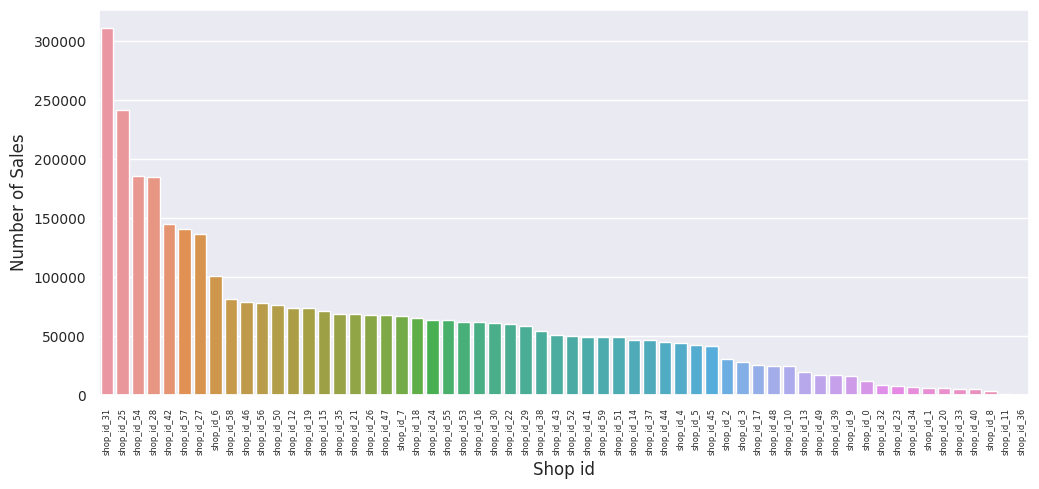

In [19]:
bar_plot_func(shops_sales, "Shop id", "Number of Sales")

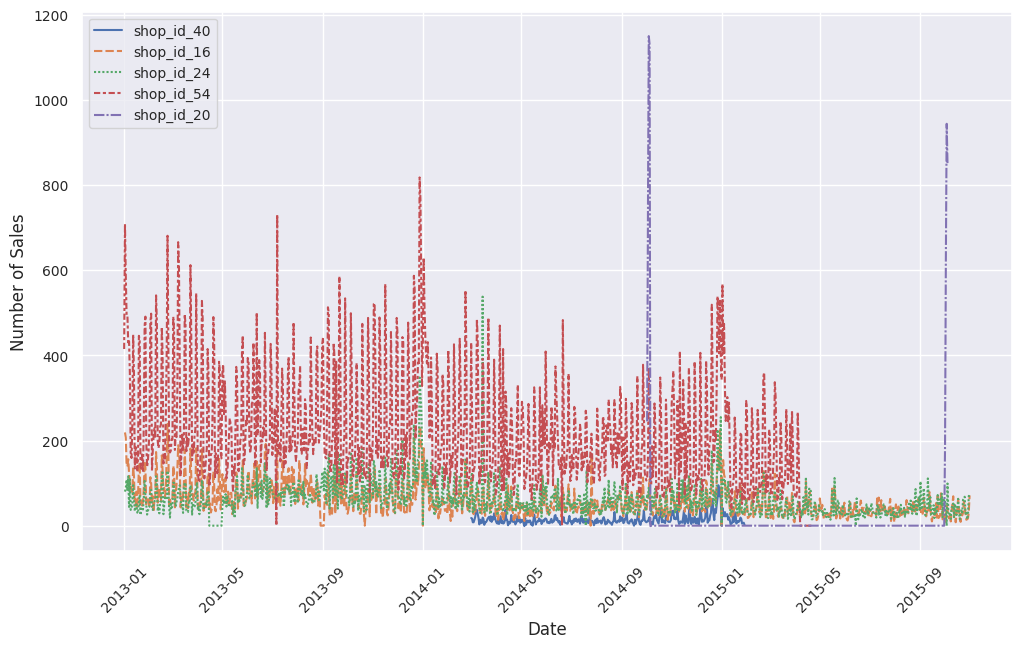

In [20]:
line_plot_func(shops_sales, number=5, ylabel="Number of Sales")

### Value of Sales (file name _shops\_values_)

In [21]:
shops_values = sort_sales(shops_df, "shop", "final_price")
shops_values.head()

shop_id_0  shop_id_1      shop_id_2  shop_id_3  shop_id_4  \
date                                                                    
2013-01-01        NaN        NaN   31886.000000        NaN        NaN   
2013-01-02        NaN        NaN   78307.007812    37305.0   122971.0   
2013-01-03   110588.0   108409.0  110521.000000    58891.0   102697.0   
2013-01-04   231122.0    45079.0   62854.000000    23231.0    88356.0   
2013-01-05   167500.0   103025.0   50181.000000    21771.0    52292.0   

            shop_id_5  shop_id_6  shop_id_7  shop_id_8  shop_id_9  ...  \
date                                                               ...   
2013-01-01        NaN        NaN    59993.0    44516.0        NaN  ...   
2013-01-02        NaN   147318.0   147332.0    97050.0        NaN  ...   
2013-01-03        NaN   133219.0   124552.0    73278.0        NaN  ...   
2013-01-04        NaN   123014.0    90173.0    80960.0        NaN  ...   
2013-01-05        NaN   107611.0   101877.0    61110.0        NaN  ...   

            shop_id_50  shop_id_51  shop_id_52  shop_id_53  shop_id_54  \
date                                                                     
2013-01-01         NaN     41411.0         NaN         NaN    319356.0   
2013-01-02    189892.0     56035.0     82783.0    105339.0    520884.0   
2013-01-03    169269.0     31080.0     76037.0     76952.5    377069.0   
2013-01-04    173310.0     37426.0     72385.0     98032.0    287218.0   
2013-01-05    143939.0     47338.0     28667.0     92861.0    401106.0   

            shop_id_55  shop_id_56  shop_id_57  shop_id_58  shop_id_59  
date                                                                    
2013-01-01         NaN         NaN         NaN         NaN         NaN  
2013-01-02         NaN    227756.0         NaN         NaN    146080.0  
2013-01-03         NaN    168691.0         NaN         NaN    156443.0  
2013-01-04         NaN    101474.0         NaN         NaN     84128.0  
2013-01-05         NaN     94114.0         NaN         NaN    103285.0  

[5 rows x 60 columns]

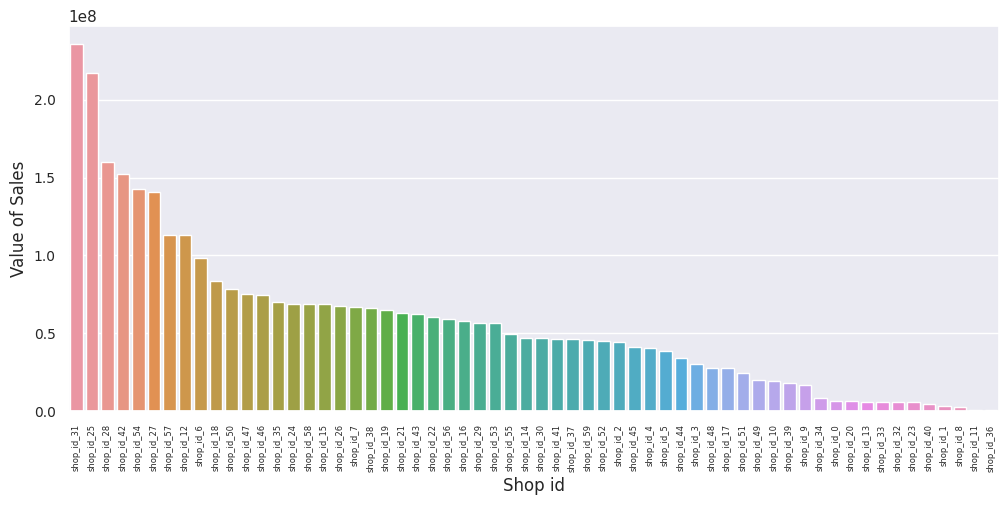

In [22]:
bar_plot_func(shops_values, "Shop id", "Value of Sales")

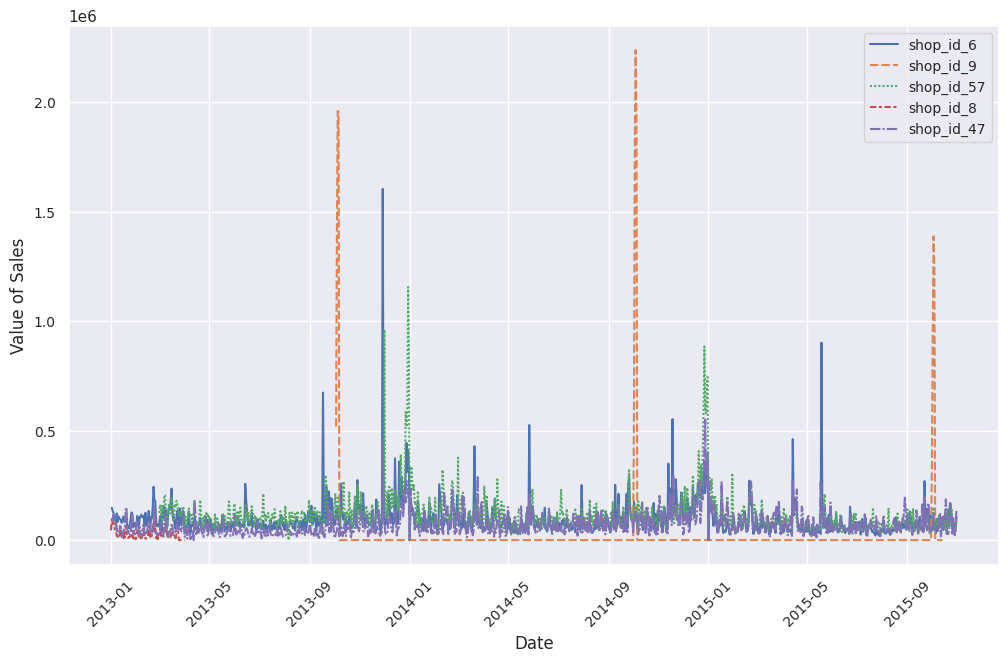

In [23]:
line_plot_func(shops_values, number=5, ylabel="Value of Sales")

## Group by Category

### Number of Sales  (file name _cats\_sales_)

In [24]:
cats_sales = sort_sales(categories_df, "cat", "item_cnt_day")
cats_sales.head()

cat_id_0  cat_id_1  cat_id_2  cat_id_3  cat_id_4  cat_id_5  \
date                                                                     
2013-01-01       NaN       NaN      30.0         7      10.0        12   
2013-01-02       NaN       NaN     116.0        41      18.0        58   
2013-01-03       NaN       NaN      84.0        32      17.0        56   
2013-01-04       NaN       NaN      77.0        24      19.0        33   
2013-01-05       NaN       NaN      79.0        25      15.0        46   

            cat_id_6  cat_id_7  cat_id_8  cat_id_9  ...  cat_id_74  cat_id_75  \
date                                                ...                         
2013-01-01        13       NaN       NaN       NaN  ...        NaN         17   
2013-01-02        64       NaN       NaN       NaN  ...        NaN         95   
2013-01-03        47       NaN       NaN       NaN  ...        NaN        126   
2013-01-04        43       NaN       NaN       NaN  ...        NaN        167   
2013-01-05        40       NaN       NaN       NaN  ...        NaN        110   

            cat_id_76  cat_id_77  cat_id_78  cat_id_79  cat_id_80  cat_id_81  \
date                                                                           
2013-01-01        NaN          4        NaN          1        NaN        1.0   
2013-01-02        NaN         31        NaN          7        NaN        9.0   
2013-01-03        NaN         30        NaN          1        NaN        7.0   
2013-01-04        NaN         16        NaN          7        NaN        8.0   
2013-01-05        NaN         18        NaN          7        NaN        7.0   

            cat_id_82  cat_id_83  
date                              
2013-01-01       16.0         35  
2013-01-02       71.0        113  
2013-01-03       41.0         64  
2013-01-04       62.0         32  
2013-01-05       57.0         38  

[5 rows x 84 columns]

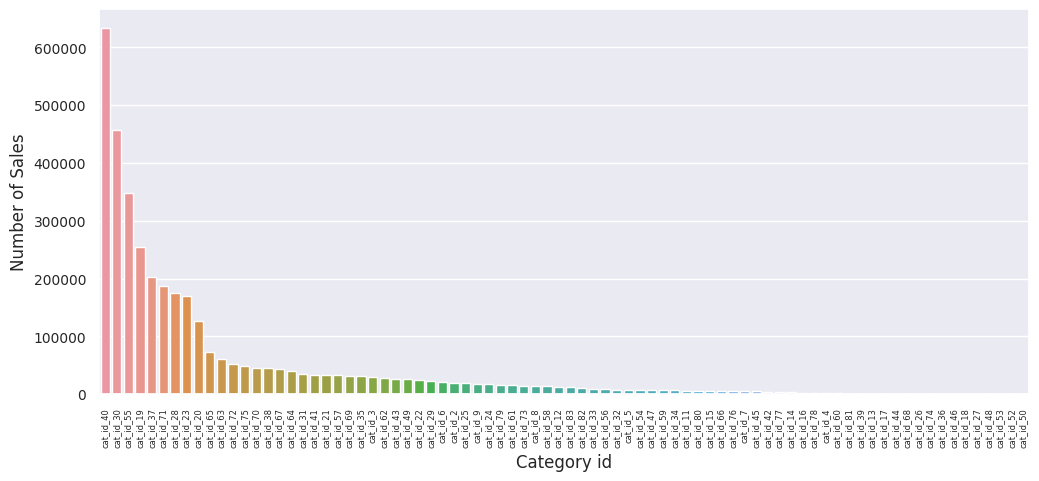

In [25]:
bar_plot_func(cats_sales, "Category id", "Number of Sales")

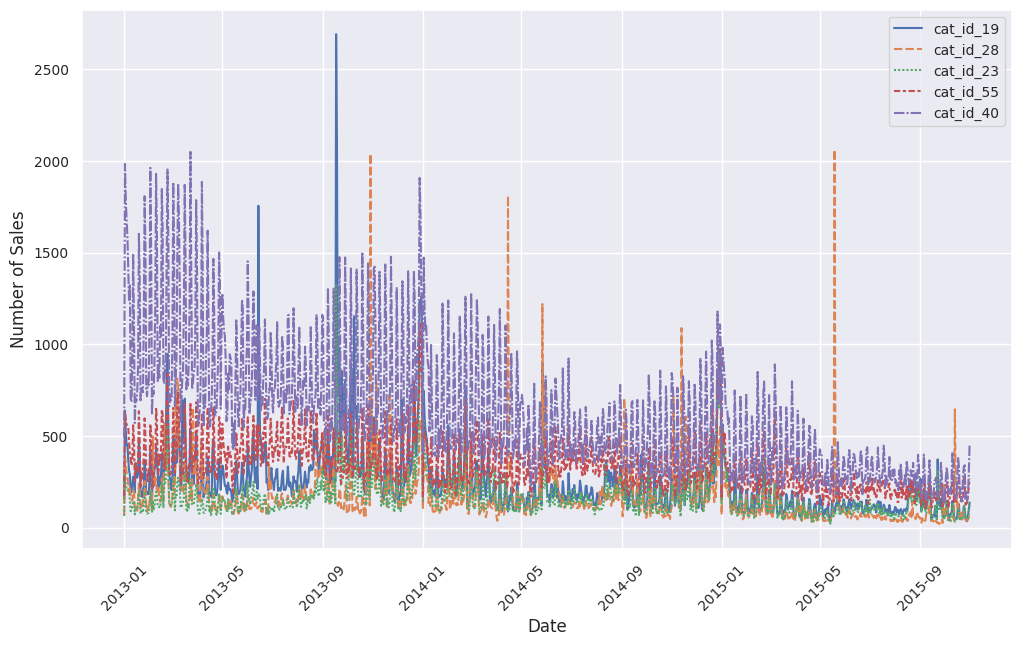

In [26]:
sample_id = ['cat_id_19', 'cat_id_28', 'cat_id_23', 'cat_id_55', 'cat_id_40']
line_plot_func(cats_sales, sample=sample_id, ylabel="Number of Sales")

### Value of Sales (file name _cats\_values_)

In [27]:
cats_values = sort_sales(categories_df, "cat", "final_price")
cats_values.head()

cat_id_0  cat_id_1       cat_id_2      cat_id_3  cat_id_4  \
date                                                                    
2013-01-01       NaN       NaN   59210.679688   3235.660156    5353.0   
2013-01-02       NaN       NaN  223635.234375  20455.240234   22371.0   
2013-01-03       NaN       NaN  166675.000000  15711.000000   20409.0   
2013-01-04       NaN       NaN  146496.515625  11205.000000   18681.5   
2013-01-05       NaN       NaN  142757.015625  11447.000000   14820.0   

                cat_id_5  cat_id_6  cat_id_7  cat_id_8  cat_id_9  ...  \
date                                                              ...   
2013-01-01   8647.299805   20769.0       NaN       NaN       NaN  ...   
2013-01-02  47024.078125  120656.5       NaN       NaN       NaN  ...   
2013-01-03  58698.320312   62046.5       NaN       NaN       NaN  ...   
2013-01-04  34044.699219   71060.0       NaN       NaN       NaN  ...   
2013-01-05  46100.101562   55896.0       NaN       NaN       NaN  ...   

            cat_id_74      cat_id_75  cat_id_76  cat_id_77  cat_id_78  \
date                                                                    
2013-01-01        NaN   32224.500000        NaN      696.0        NaN   
2013-01-02        NaN  188437.000000        NaN     5554.0        NaN   
2013-01-03        NaN  210710.796875        NaN     5693.0        NaN   
2013-01-04        NaN  262702.000000        NaN     2985.0        NaN   
2013-01-05        NaN  157989.703125        NaN     3792.0        NaN   

            cat_id_79  cat_id_80  cat_id_81  cat_id_82     cat_id_83  
date                                                                  
2013-01-01      499.0        NaN       79.0      447.0   2580.000000  
2013-01-02     3593.0        NaN     1871.0     2522.0  10122.870117  
2013-01-03      599.0        NaN      951.0     1023.0   5546.000000  
2013-01-04     3393.0        NaN     1568.0     1814.0   3013.000000  
2013-01-05     3623.0        NaN     1989.0     1662.0   3294.000000  

[5 rows x 84 columns]

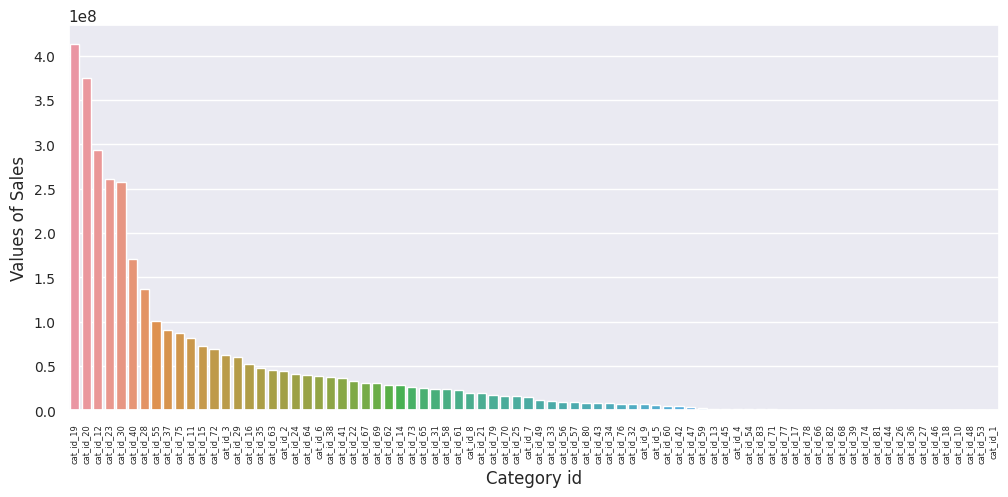

In [28]:
bar_plot_func(cats_values, "Category id", "Values of Sales")

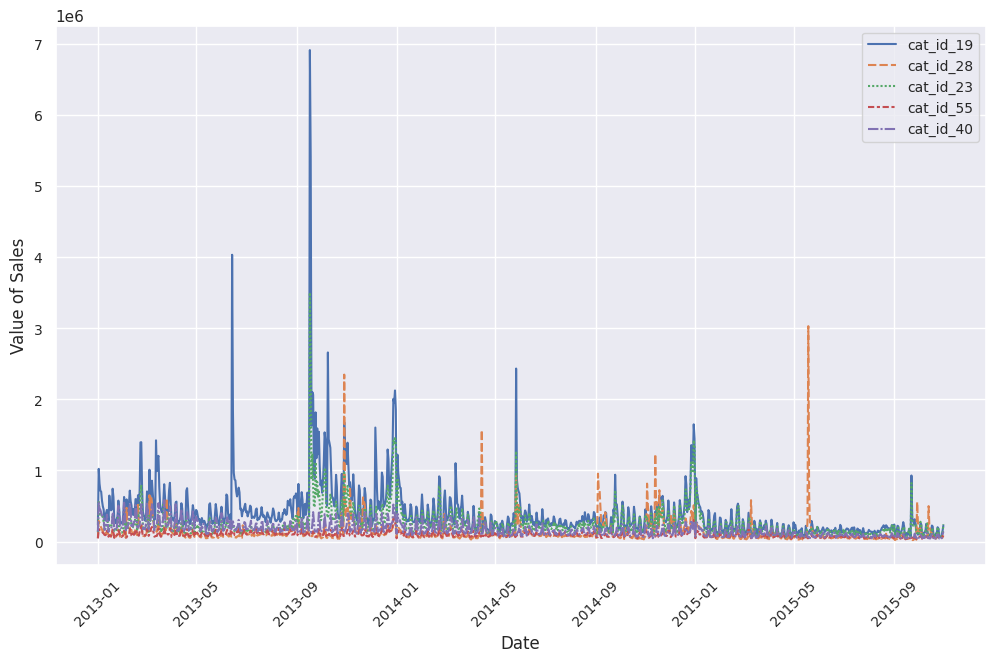

In [29]:
sample_id = ['cat_id_19', 'cat_id_28', 'cat_id_23', 'cat_id_55', 'cat_id_40']
line_plot_func(cats_values, sample=sample_id, ylabel="Value of Sales")

## Group by item

### Cleaning the data with the _test\_df_ Data Frame as base line

First we will remove the categories that don't show in the _test\_df_, to reduce the amount of data. The amount of data is to big, and will make analysis difficult. And those shops, categories and items have really small number on the sales.

In [30]:
unique_shops = np.sort(test_df['shop_id'].unique())
unique_shops, len(unique_shops)

(array([ 2,  3,  4,  5,  6,  7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25,
        26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49,
        50, 52, 53, 55, 56, 57, 58, 59]),
 42)

In [31]:
unique_cats = np.sort(test_df['cat_id'].unique())
unique_cats, len(unique_cats)

(array([ 0,  2,  3,  5,  6,  7,  9, 11, 12, 15, 16, 19, 20, 21, 22, 23, 24,
        25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43,
        44, 45, 47, 49, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 67, 69,
        70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 83]),
 62)

In [32]:
unique_item = np.sort(test_df['item_id'].unique())
unique_item, len(unique_item)

(array([   30,    31,    32, ..., 22164, 22166, 22167]), 5100)

In [33]:
sales_clean_df = sales_df[
    sales_df['shop_id'].isin(unique_shops)
    & sales_df['cat_id'].isin(unique_cats)
    & sales_df['item_id'].isin(unique_item)
]
sales_clean_df

date  date_block_num  shop_id  item_id   item_price  \
1005087 2013-01-01               0       14    15438   599.000000   
128444  2013-01-01               0       41     1523   799.000000   
128357  2013-01-01               0       28     1523   799.000000   
128396  2013-01-01               0       14     1523   799.000000   
760355  2013-01-01               0       15     8685   199.000000   
...            ...             ...      ...      ...          ...   
1788495 2015-10-31              33       58     3734  3399.000000   
2715396 2015-10-31              33       58    17748   288.149994   
1502745 2015-10-31              33       26    20949     5.000000   
2931438 2015-10-31              33       46     7223  3999.000000   
2922155 2015-10-31              33       31     3352  2999.000000   

         item_cnt_day  cat_id  final_price  
1005087             1      63   599.000000  
128444              1      21   799.000000  
128357              1      21   799.000000  
128396              1      21   799.000000  
760355              1      55   199.000000  
...               ...     ...          ...  
1788495             1      23  3399.000000  
2715396             1      70   288.149994  
1502745             3      71    15.000000  
2931438             1      20  3999.000000  
2922155             1      23  2999.000000  

[1224439 rows x 8 columns]

In [34]:
print(
    f"sales_df Rows: {sales_df.shape[0]}",
    f"sales_clean_df Reows: {sales_clean_df.shape[0]}",
    sep='\n'
)

sales_df Rows: 2935849
sales_clean_df Reows: 1224439


### Number of Sales (file name _items\_sales_)

In [35]:
items_sales = pd.pivot_table(
    sales_clean_df, values='item_cnt_day',
    index=['item_id'], columns=['date'],
    aggfunc=np.sum 
)
items_sales.fillna(0, inplace=True)
items_sales = items_sales.T

In [36]:
items_sales.head()

item_id     30     31     32     33     38     42     45     51     53     \
date                                                                        
2013-01-01    0.0    0.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0   
2013-01-02    0.0    0.0   12.0    3.0    0.0    0.0    1.0    0.0    1.0   
2013-01-03    0.0    0.0   15.0    1.0    0.0    0.0    1.0    2.0    1.0   
2013-01-04    0.0    0.0   11.0    2.0    0.0    0.0    0.0    0.0    0.0   
2013-01-05    0.0    0.0   14.0    4.0    0.0    0.0    0.0    1.0    0.0   

item_id     57     ...  22111  22118  22139  22145  22154  22162  22163  \
date               ...                                                    
2013-01-01    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2013-01-02    0.0  ...    0.0    0.0    1.0    0.0    3.0    0.0    0.0   
2013-01-03    0.0  ...    1.0    0.0    2.0    0.0    1.0    0.0    0.0   
2013-01-04    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2013-01-05    0.0  ...    0.0    0.0    1.0    0.0    1.0    0.0    0.0   

item_id     22164  22166  22167  
date                             
2013-01-01    0.0    0.0    0.0  
2013-01-02    0.0    0.0    0.0  
2013-01-03    0.0    0.0    0.0  
2013-01-04    0.0    0.0    0.0  
2013-01-05    0.0    0.0    0.0  

[5 rows x 4716 columns]

In [37]:
items_sales.sum().sort_values(ascending=False)

item_id
20949    154077.0
2808      13955.0
3732      13582.0
17717     13553.0
5822      12268.0
           ...   
12400         1.0
21001         1.0
21007         1.0
21010         1.0
5959          1.0
Length: 4716, dtype: float64

<AxesSubplot: ylabel='Percent'>

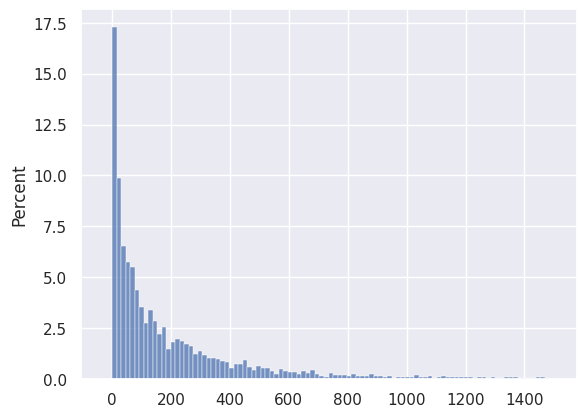

In [38]:
xxx = items_sales.sum().sort_values(ascending=False)
sns.histplot(xxx, stat='percent', bins=100, binrange=(-30, 1_500))
#plt.xlim(left=-100, right=1_500)
#plt.ylim(top=900)

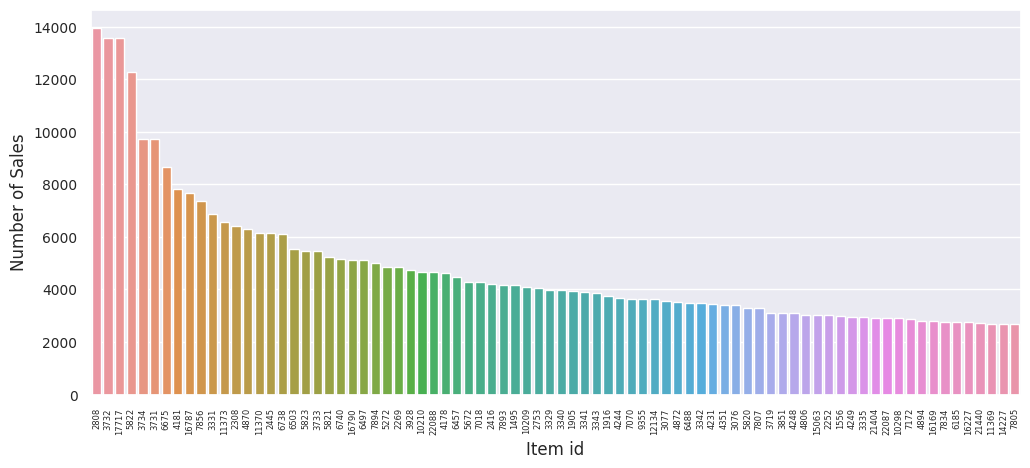

In [163]:
bar_plot_func(items_sales, "Item id", "Number of Sales", start=1)

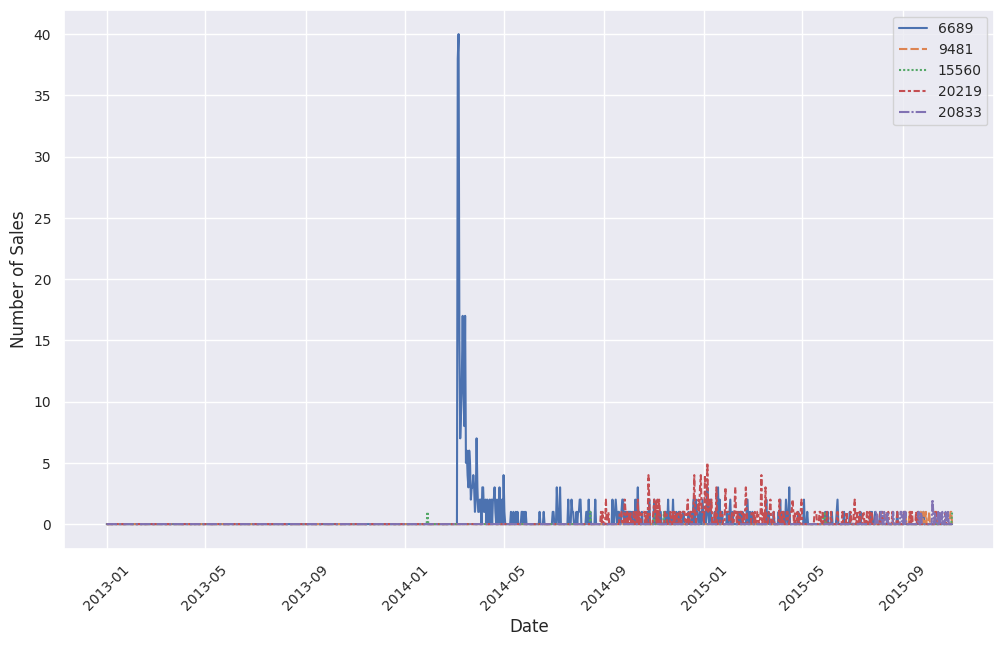

In [40]:
line_plot_func(items_sales, number=5, ylabel=f"Number of Sales")

### Values of Sales (file name _items\_values_)

In [41]:
items_values = pd.pivot_table(
    sales_clean_df, values='final_price',
    index=['item_id'], columns=['date'],
    aggfunc=np.sum 
)
items_values.fillna(0, inplace=True)
items_values = items_values.T

In [42]:
items_values.head()

item_id     30     31           32      33     38     42     45     51     \
date                                                                        
2013-01-01    0.0    0.0  1395.439941     0.0    0.0    0.0    0.0    0.0   
2013-01-02    0.0    0.0  4186.870117  1497.0    0.0    0.0  299.0    0.0   
2013-01-03    0.0    0.0  5217.549805   499.0    0.0    0.0  299.0  498.0   
2013-01-04    0.0    0.0  3839.000000   998.0    0.0    0.0    0.0    0.0   
2013-01-05    0.0    0.0  4886.000000  1996.0    0.0    0.0    0.0  249.0   

item_id     53     57     ...  22111  22118        22139  22145   22154  \
date                      ...                                             
2013-01-01    0.0    0.0  ...    0.0    0.0     0.000000    0.0     0.0   
2013-01-02  299.0    0.0  ...    0.0    0.0   791.119995    0.0  2997.0   
2013-01-03  299.0    0.0  ...  349.0    0.0  1998.000000    0.0   999.0   
2013-01-04    0.0    0.0  ...    0.0    0.0     0.000000    0.0     0.0   
2013-01-05    0.0    0.0  ...    0.0    0.0   899.369995    0.0   999.0   

item_id     22162  22163  22164  22166  22167  
date                                           
2013-01-01    0.0    0.0    0.0    0.0    0.0  
2013-01-02    0.0    0.0    0.0    0.0    0.0  
2013-01-03    0.0    0.0    0.0    0.0    0.0  
2013-01-04    0.0    0.0    0.0    0.0    0.0  
2013-01-05    0.0    0.0    0.0    0.0    0.0  

[5 rows x 4716 columns]

In [43]:
items_values.sum().sort_values(ascending=False)

item_id
6675     185097376.0
3732      35825964.0
3734      26103438.0
3731      19258302.0
3733      18826444.0
            ...     
18707          149.0
8247           149.0
342            144.0
4491            99.0
180             80.0
Length: 4716, dtype: float32

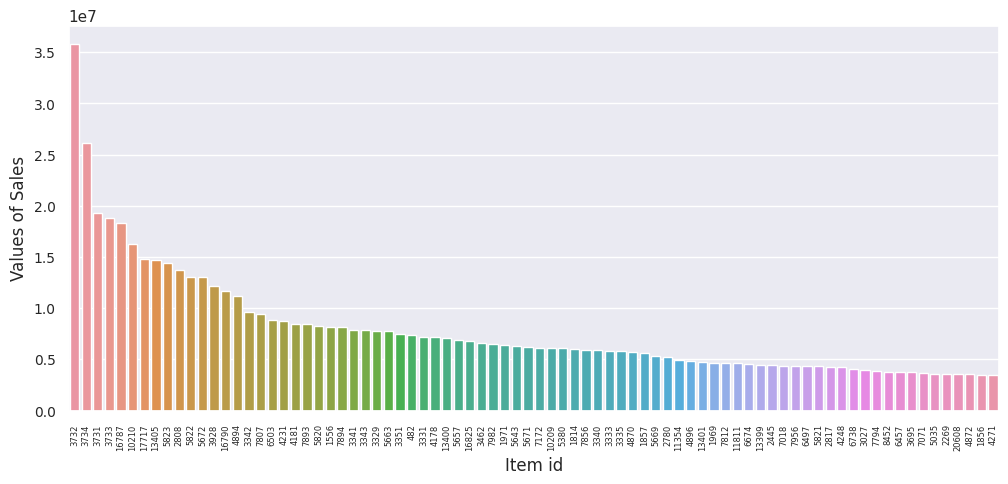

In [44]:
bar_plot_func(items_values, "Item id", "Values of Sales", start=1)

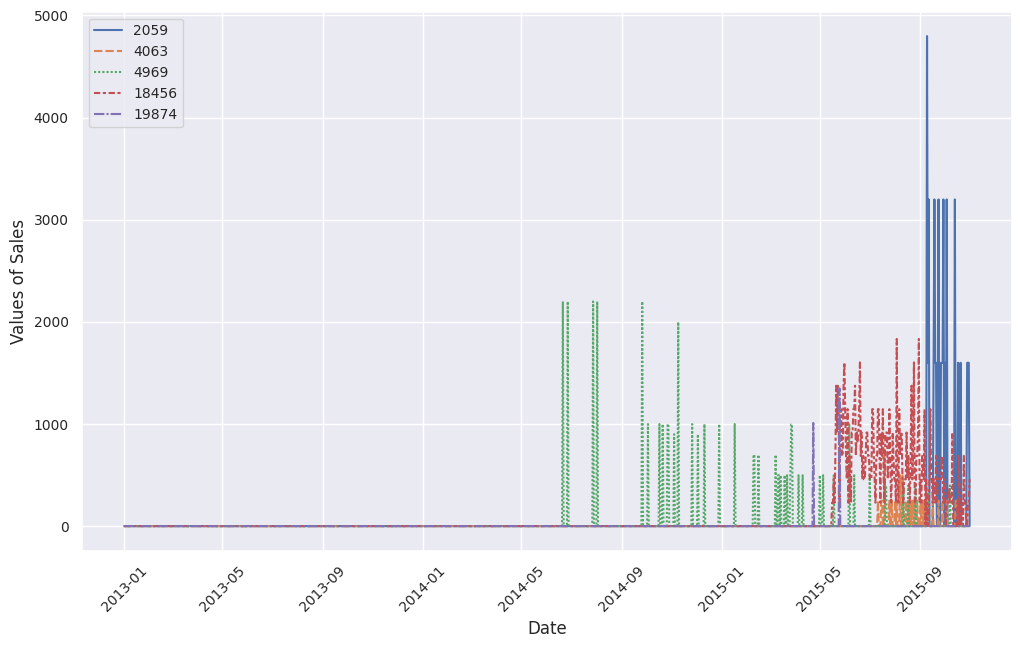

In [45]:
line_plot_func(items_values, number=5, ylabel=f"Values of Sales")

## Group  Categories by Shop

### Number of Sales (file name _cats_shops_sales_)

In [46]:
cats_shops_sales = pd.pivot_table(
    sales_clean_df, values='item_cnt_day',
    index=['shop_id', 'cat_id'], columns=['date'],
    aggfunc=np.sum 
)
cats_shops_sales.fillna(0, inplace=True)
cats_shops_sales = cats_shops_sales.T

In [47]:
cats_shops_sales.head()

shop_id      2                                                ...   59       \
cat_id       2    3    5    6    7    11   12   15   16   19  ...   67   69   
date                                                          ...             
2013-01-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2013-01-02  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  2.0  0.0   
2013-01-03  2.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  2.0  ...  1.0 -2.0   
2013-01-04  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  3.0  0.0   
2013-01-05  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  ...  1.0  0.0   

shop_id                                             
cat_id       70   71   72   73   75   77   79   83  
date                                                
2013-01-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2013-01-02  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2013-01-03  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
2013-01-04  0.0  0.0  0.0  0.0  3.0  0.0  0.0  0.0  
2013-01-05  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  

[5 rows x 2008 columns]

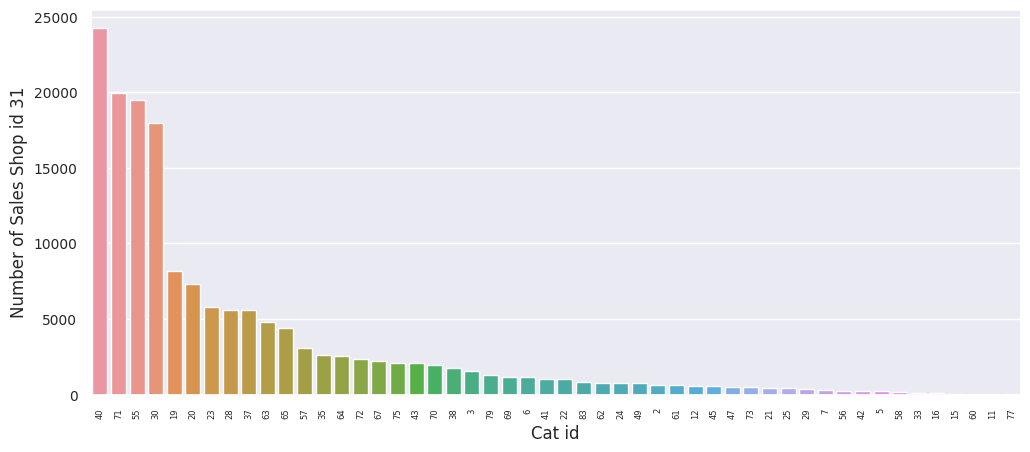

In [48]:
shop_id = 31
bar_plot_func(cats_shops_sales[shop_id], "Cat id", f"Number of Sales Shop id {shop_id}")

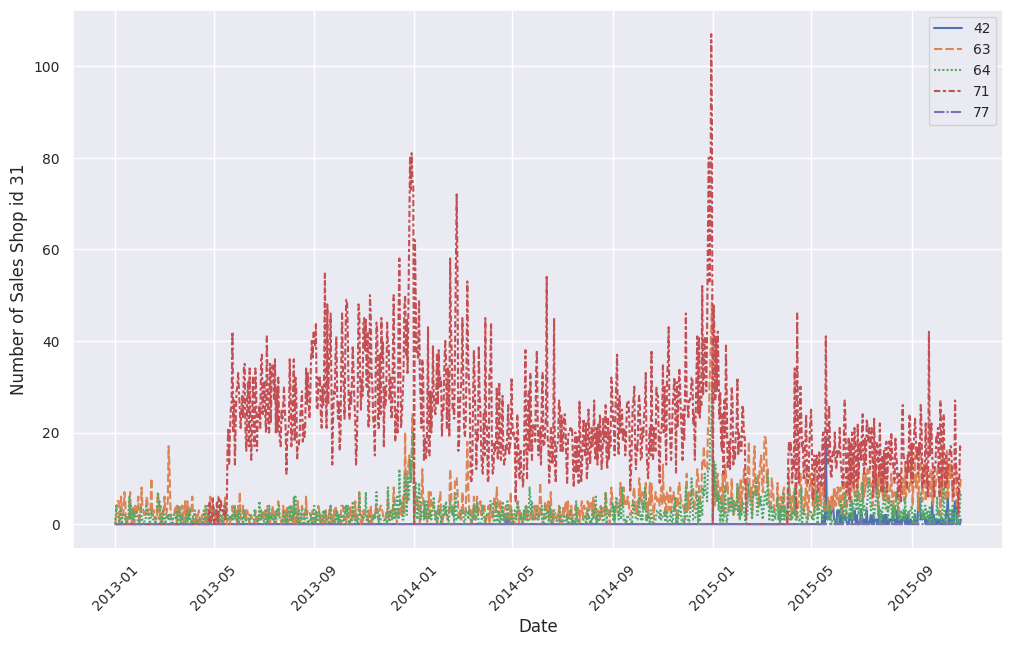

In [49]:
line_plot_func(cats_shops_sales[shop_id], number=5, ylabel=f"Number of Sales Shop id {shop_id}")

### Value of Sales (file name cats_shops_values)

In [50]:
cats_shops_values = pd.pivot_table(
    sales_clean_df, values='final_price',
    index=['shop_id', 'cat_id'], columns=['date'],
    aggfunc=np.sum 
)
cats_shops_values.fillna(0, inplace=True)
cats_shops_values = cats_shops_values.T

In [51]:
cats_shops_values.head()

shop_id         2                                                             \
cat_id          2    3           5       6    7    11   12   15   16      19   
date                                                                           
2013-01-01     0.0  0.0    0.000000     0.0  0.0  0.0  0.0  0.0  0.0     0.0   
2013-01-02  3180.0  0.0    0.000000     0.0  0.0  0.0  0.0  0.0  0.0  1199.0   
2013-01-03  3180.0  0.0  489.299988  1990.0  0.0  0.0  0.0  0.0  0.0  1798.0   
2013-01-04     0.0  0.0  699.000000     0.0  0.0  0.0  0.0  0.0  0.0     0.0   
2013-01-05  1590.0  0.0    0.000000     0.0  0.0  0.0  0.0  0.0  0.0  2698.0   

shop_id     ...      59                                                   
cat_id      ...      67   69   70   71   72   73      75   77   79    83  
date        ...                                                           
2013-01-01  ...     0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  
2013-01-02  ...  1298.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  
2013-01-03  ...   299.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  79.0  
2013-01-04  ...  1670.0  0.0  0.0  0.0  0.0  0.0  3450.0  0.0  0.0   0.0  
2013-01-05  ...   949.0  0.0  0.0  0.0  0.0  0.0  3500.0  0.0  0.0   0.0  

[5 rows x 2008 columns]

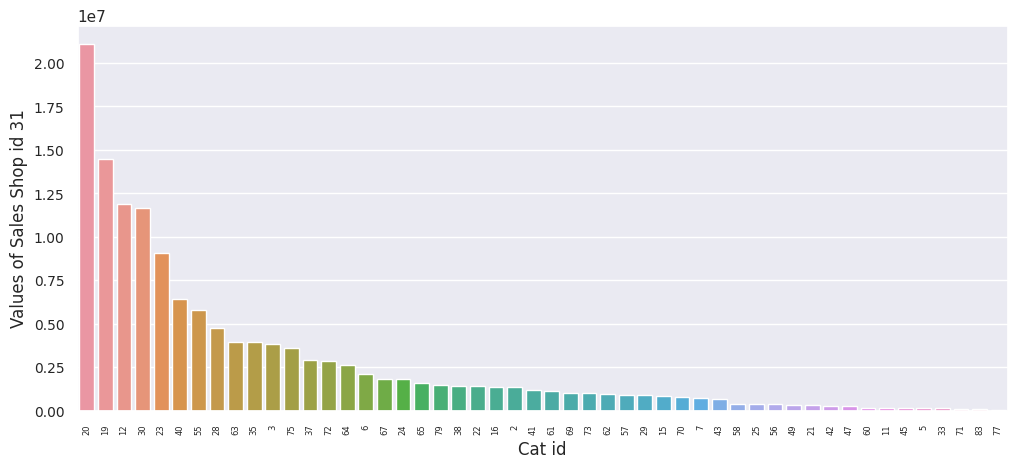

In [52]:
shop_id = 31
bar_plot_func(cats_shops_values[shop_id], "Cat id", f"Values of Sales Shop id {shop_id}")

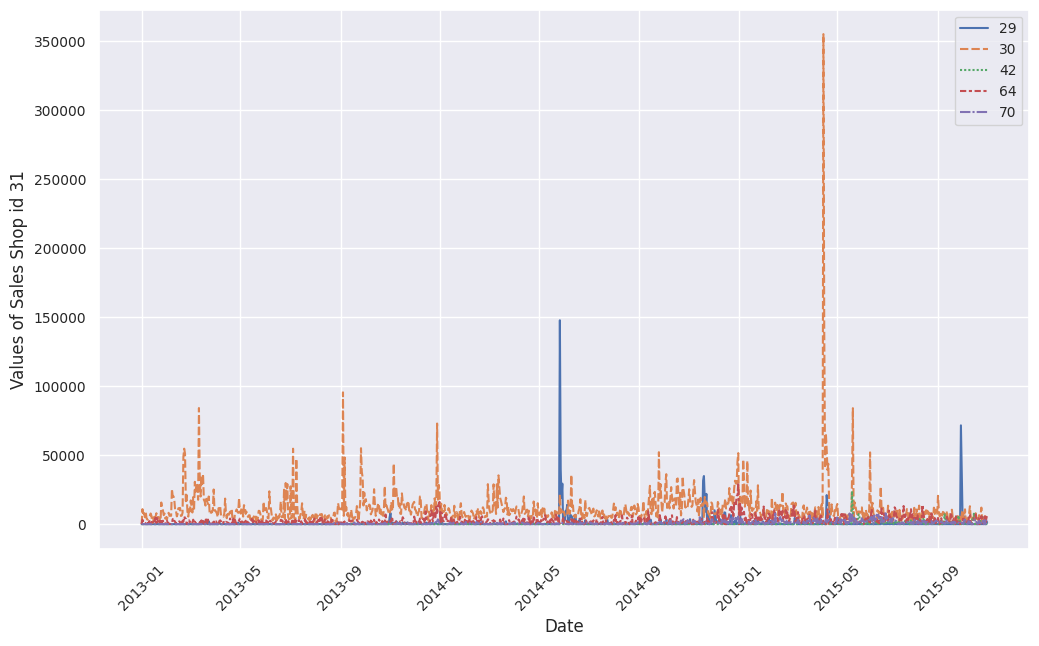

In [53]:
line_plot_func(cats_shops_values[shop_id], number=5, ylabel=f"Values of Sales Shop id {shop_id}")

## Total

### Files names: _total\_sales_ and _total\_values_

In [54]:
total_sales = sales_df.resample(freq_analysis, on="date").sum()[['item_cnt_day']]
total_values = sales_df.resample(freq_analysis, on="date").sum()[['final_price']]

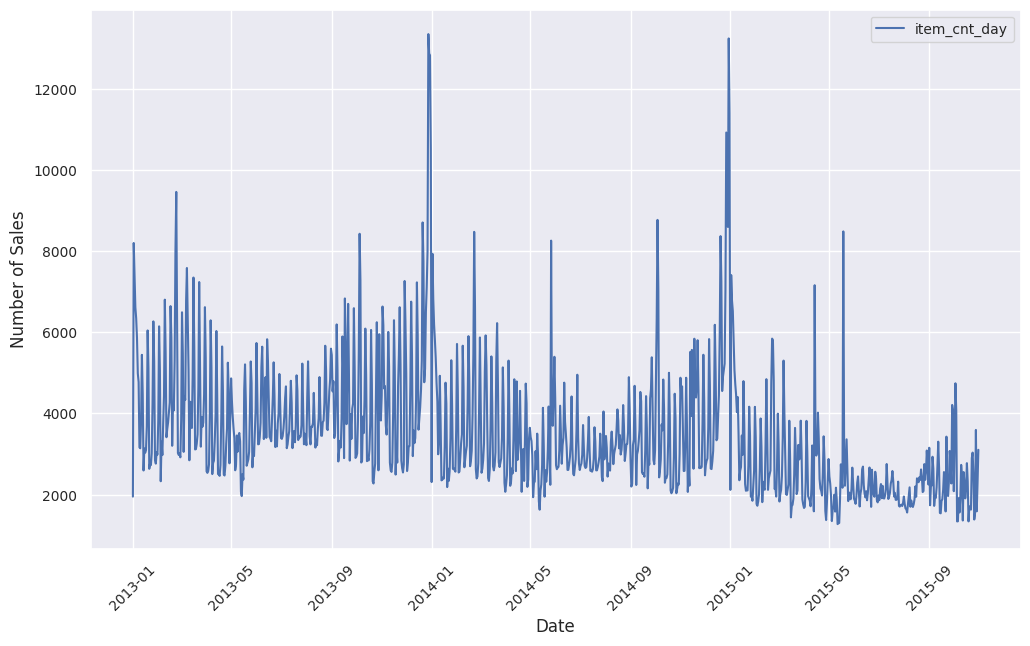

In [55]:
line_plot_func(total_sales, 1, ylabel="Number of Sales")

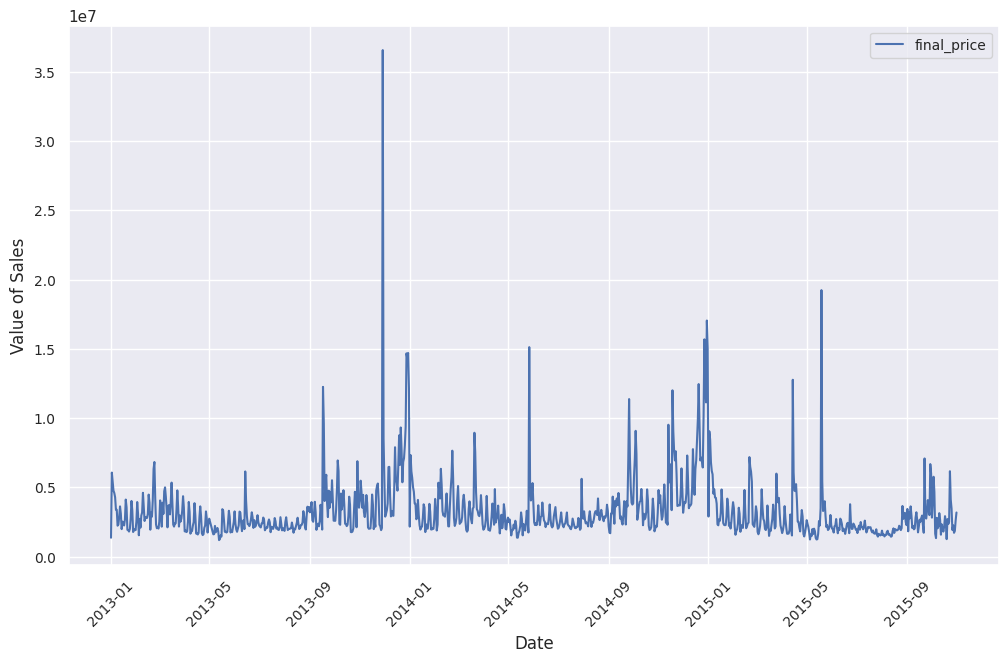

In [56]:
line_plot_func(total_values, 1, ylabel="Value of Sales")

# Model Prophet
___

## Model Functions

In [57]:
# plot graph with train test and predict
def plot_forecast(prophet_dict: dict, test=True, pred=True, lower=False, upper=False, left=None, right=None) -> None:
    """
    Plot the train, test and forecast data.
    prophet_dict: prophet_model dictionary
    test, pred, lower, upper: turn on and off the plots.
    left, right: sets the x-axis limits, in date format.
    """
    plt.figure(figsize=(15, 8))
    
    # plots
    plt.plot(prophet_dict['train']['ds'], prophet_dict['train']['y'], label="Train")
    if test:
        plt.plot(prophet_dict['test']['ds'], prophet_dict['test']['y'], label="Test")
    if pred:
        plt.plot(
            prophet_dict['forecast'][-prophet_dict['horizon']:]['ds'],
            prophet_dict['forecast'][-prophet_dict['horizon']:]['yhat'],
            label="Pred")
    if lower:
        plt.plot(
            prophet_dict['forecast'][-prophet_dict['horizon']:]['ds'],
            prophet_dict['forecast'][-prophet_dict['horizon']:]['yhat_lower'],
            label="Lower")
    if upper:
        plt.plot(prophet_dict['forecast'][-prophet_dict['horizon']:]['ds'],
                 prophet_dict['forecast'][-prophet_dict['horizon']:]['yhat_upper'],
                 label="Upper")
    
    # x and y axis limits
    if left is not None:
        left = dt.datetime.strptime(left, '%Y-%m').date()
    if right is not None:
        right = dt.datetime.strptime(right, '%Y-%m').date()
    plt.xlim(left=left, right=right)    
    
    plt.legend(loc="best")
    plt.show()

In [58]:
# function to split the data between train and test
def set_train_data(df, split, frequency):
    """
    Split the Data Frame between train and test, if there is no need for test use split=1.
    df: Data Frame
    split: size (%) of the train data
    frequency: month, week, day
    """
    
    # Rename Columns to Prophet format
    df = df.reset_index()
    df.columns = ['ds', 'y']
    
    # Set size train and test df
    shape = df.shape[0]
    train_size = int(shape * split)
    train = df.iloc[:train_size]
    test = df.iloc[train_size:]
    
    # Set the horizin to predict
    horizon_dict = {'m': 2, 'w': 8, 'd':62} # two month, four weeks, 62 days
    horizon = (horizon_dict[frequency]) + (shape - train_size)
    return train, test, horizon

In [59]:
# fit the Prophet model
def prophet_model(df, split=1, seas_scale=10, inter_w=0.80, freq='d') -> dict:
    """
    Fit the whole model with FB Prophet.
    ------------------------------------
    data: the data to be used.
    split: Split between train and test, if there is no need for test use split=1.
    (seas_scale) seasonality_prior_scale:
        Larger values allow the model to fit larger seasonal fluctuations,
        smaller values dampen the seasonality.
    (inter_w) interval_width:
        Float, width of the uncertainty intervals provided for the forecast.
        Uses the MAP estimate of the extrapolated generative model.
    freq: Used to create the frequency (day, week, month), of train, test, forecast and horizon
    """
    # Split the data
    train_df, test_df, horizon = set_train_data(df, split, freq)
    
    # Prophet model fit
    model = prophet_fit(train_df, seas_scale, inter_w)
    
    # future prediction
    forecast = future_preds(model, horizon, freq)
    
    # dict with model, split data and forecast
    prophet_dict = {'model':model,
        'forecast':forecast,
        'train':train_df,
        'test':test_df,
        'horizon':horizon
    }
    
    return prophet_dict

In [60]:
# Prophet model
def prophet_fit(train_df, seas_scale, inter_w):
    model = Prophet(
        seasonality_mode='multiplicative', # or 'additive'
        seasonality_prior_scale=seas_scale, # default 10, smaller values dampen the seasonality
        interval_width=inter_w, # deaful 0.8, if mcmc < 0 will be integrated over all model parameters
        growth='linear', # is the default
        #yearly_seasonality=False, # default 'auto'
        #weekly_seasonality=True, # default 'auto'
        #daily_seasonality=False, # default 'auto'
        mcmc_samples=0, # default 0, if greater than 0, will do full Bayesian inference
    )
    return model.fit(train_df)    

In [61]:
# make future predictions
def future_preds(model, horizon, freq):
    """
    Return the forecast for a given model, frequency and horizon
    """
    future = model.make_future_dataframe(periods=horizon, freq=freq, )
    forecast = model.predict(future)
    # forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    return forecast    

In [62]:
def get_forecast_data(prophet_dict: dict):
    """
    Input is the dict return of the prophet_model function.
    Get the forecast for the predictions, by days (61), weeks (4) or month (2).
    """
    row_start = prophet_dict['train'].shape[0]+1
    df = prophet_dict['forecast'][row_start:][['ds', 'yhat']]
    
    day_pred = df[['ds']].join(df['yhat'].round(2))
    week_pred = day_pred.resample('w', on='ds').mean().round(2).head(8)
    month_pred = day_pred.resample('m', on='ds').mean().round(2).head(2)
    
    forecast = {
        'day': day_pred,
        'week': week_pred,
        'month': month_pred
    }
    
    return forecast

## Evaluate Model for Total Data, _sales_ and _values_

### Fitting the Data and Making Future Predictions

In [63]:
# total_Shops_Number_sales
prophet_total_shops_sales = prophet_model(
    total_sales,
    split=0.90,
    seas_scale=10,
    inter_w=0.80,
    freq=freq_analysis
)

# total_Shops_Values
prophet_total_shops_values = prophet_model(
    total_values,
    split=0.90,
    seas_scale=10,
    inter_w=0.80,
    freq=freq_analysis
)

00:28:09 - cmdstanpy - INFO - Chain [1] start processing
00:28:09 - cmdstanpy - INFO - Chain [1] done processing
00:28:09 - cmdstanpy - INFO - Chain [1] start processing
00:28:09 - cmdstanpy - INFO - Chain [1] done processing


### Plotting the forecast test

#### Total Number of Sales

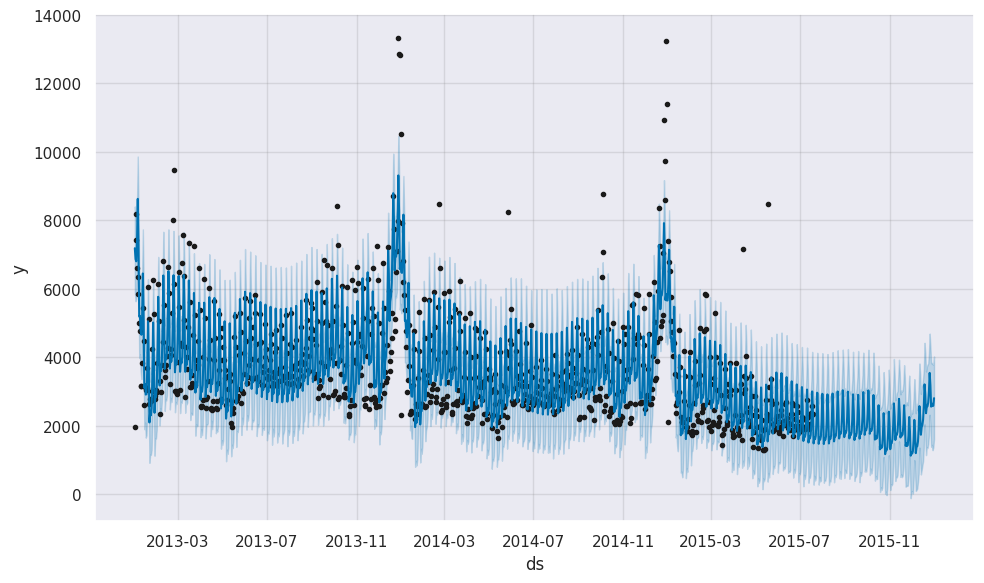

In [64]:
prophet_total_shops_sales['model'].plot(prophet_total_shops_sales['forecast']);

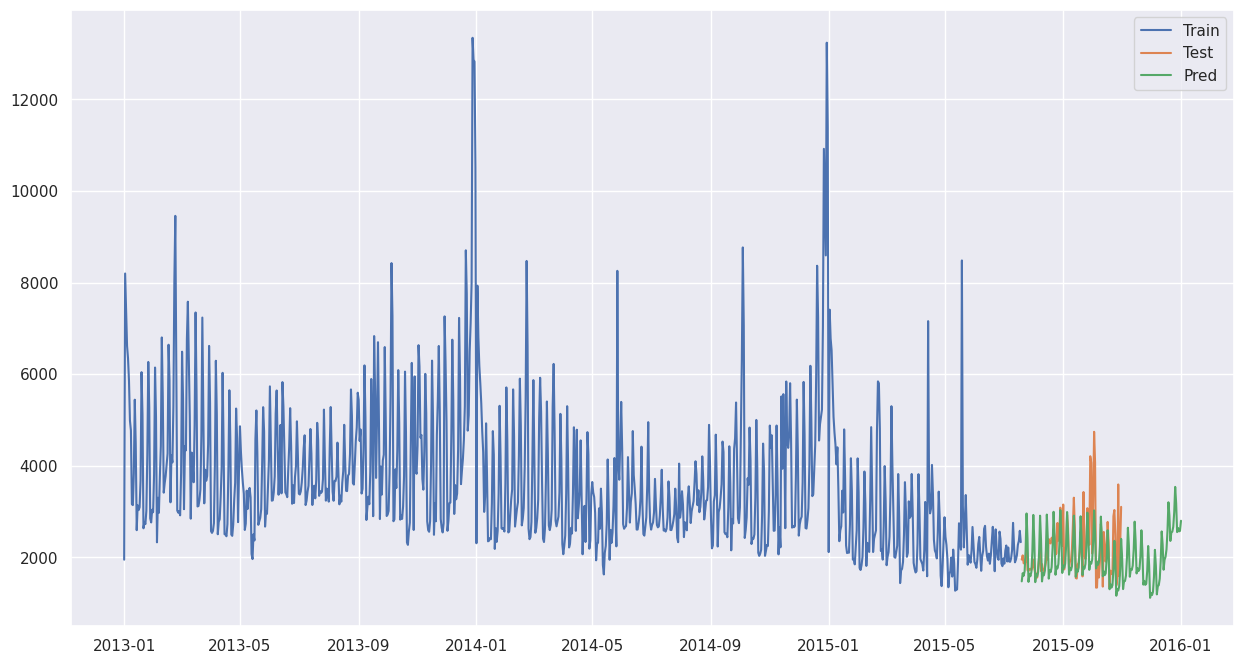

In [65]:
plot_forecast(prophet_total_shops_sales)

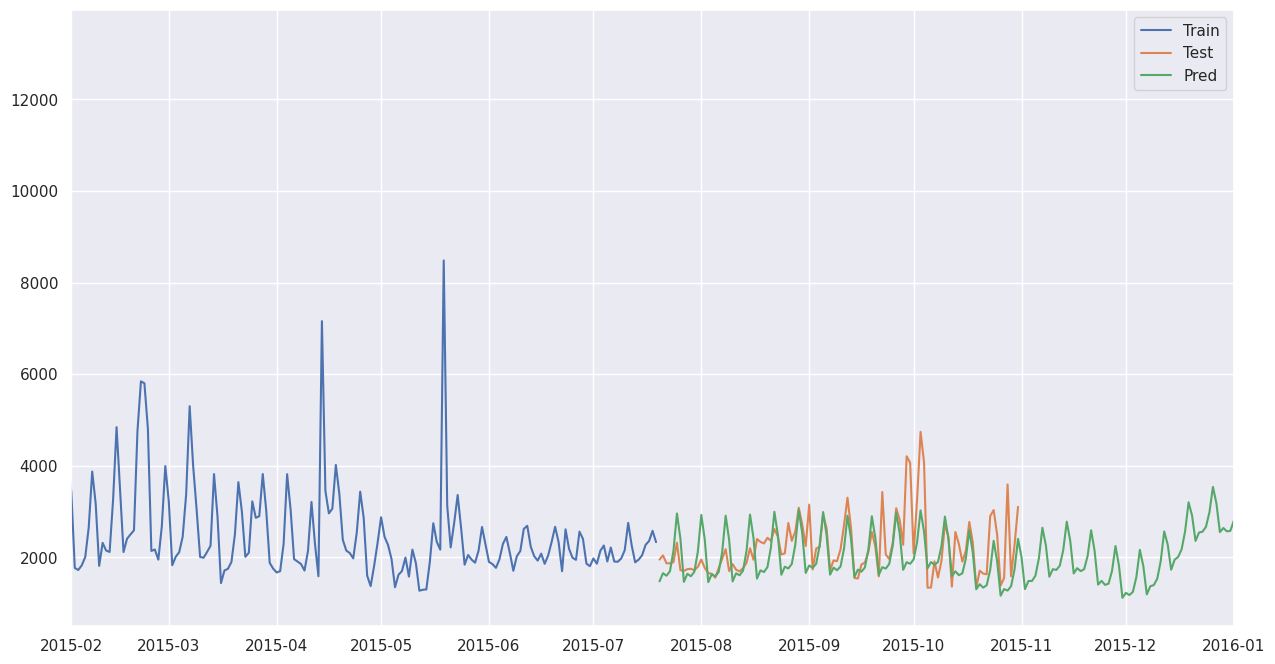

In [66]:
plot_forecast(prophet_total_shops_sales, left='2015-02', right='2016-01')

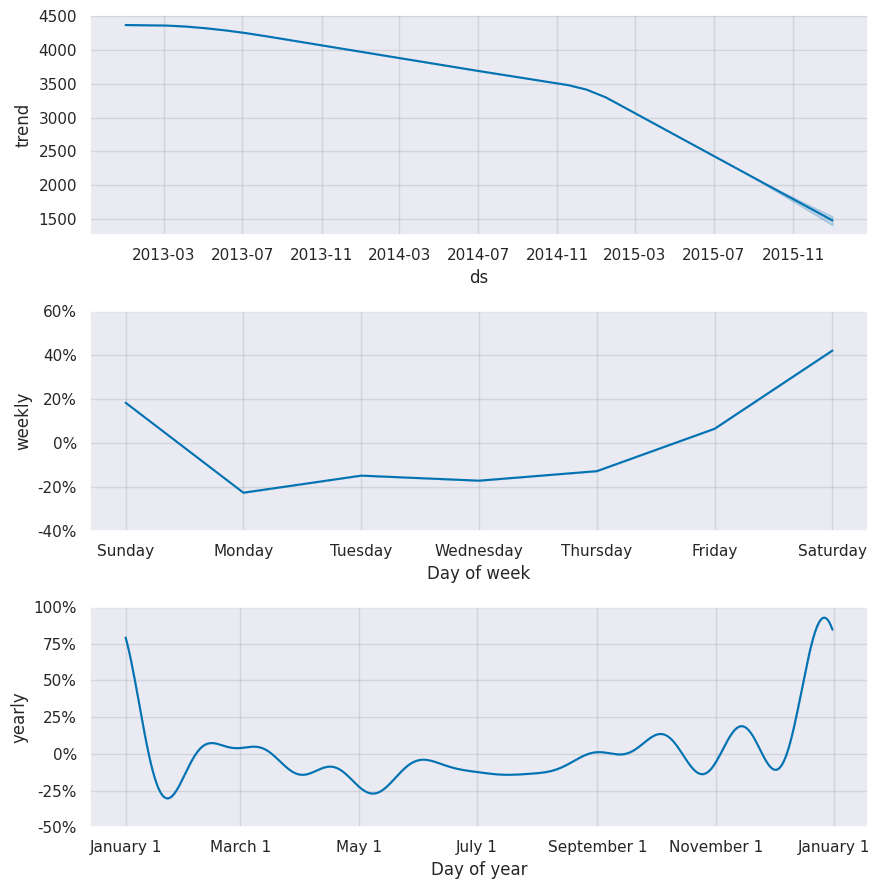

In [67]:
prophet_total_shops_sales['model'].plot_components(prophet_total_shops_sales['forecast']);

#### Total Value of Sales

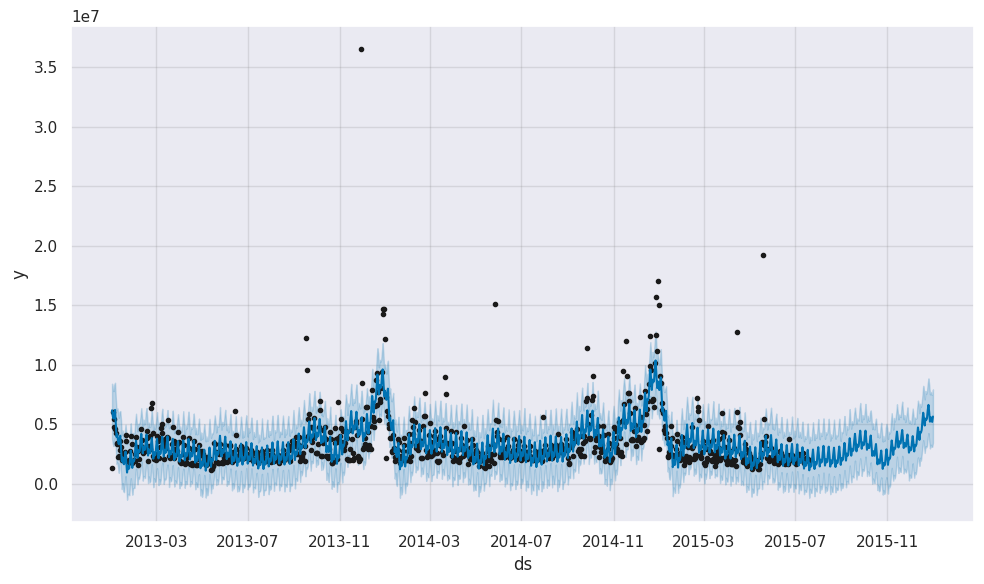

In [68]:
prophet_total_shops_values['model'].plot(prophet_total_shops_values['forecast']);

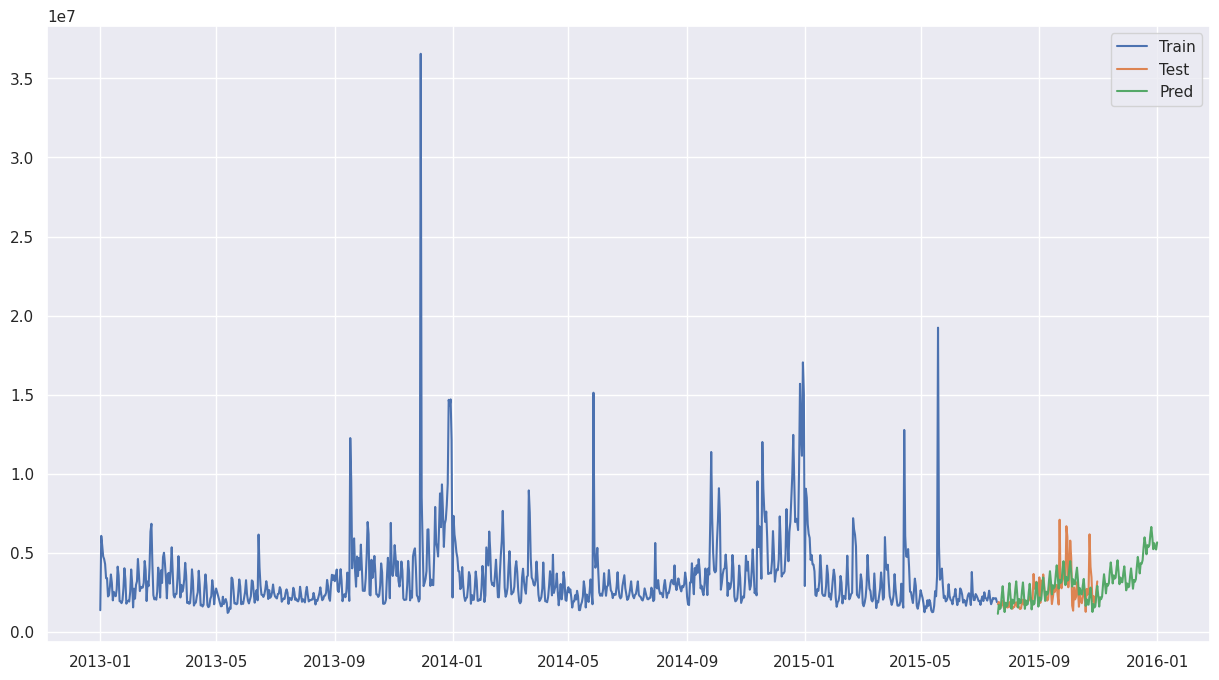

In [69]:
plot_forecast(prophet_total_shops_values)

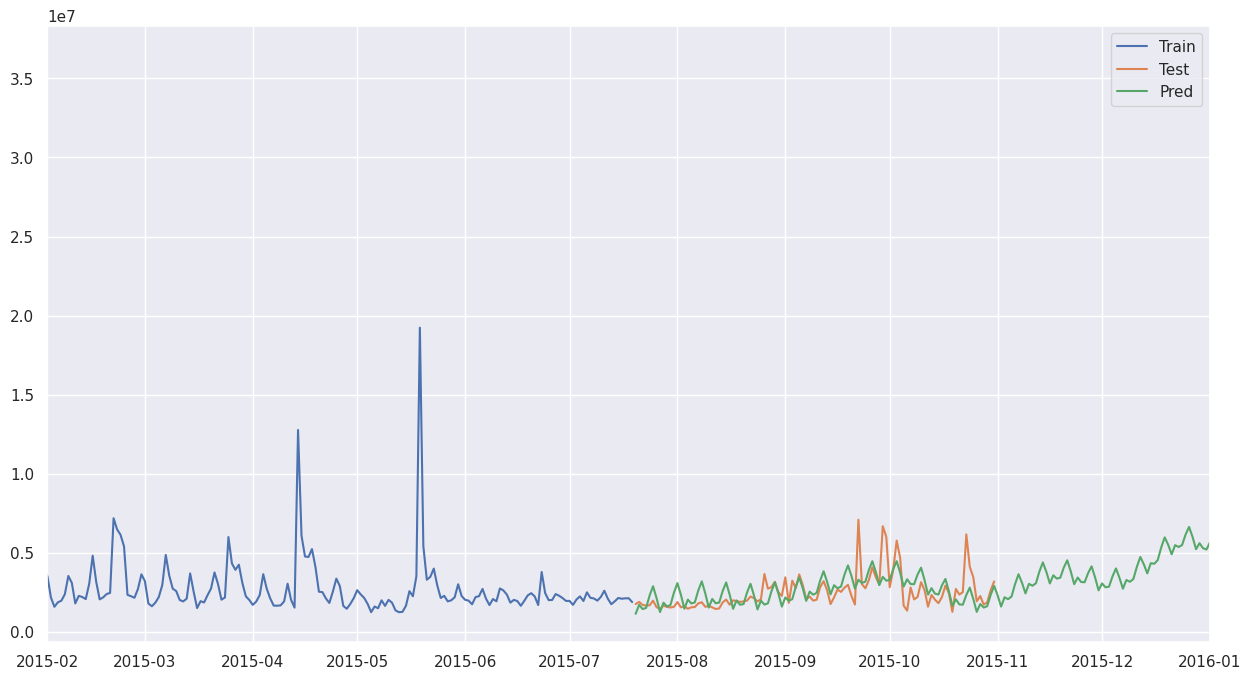

In [70]:
plot_forecast(prophet_total_shops_values, left='2015-02', right='2016-01')

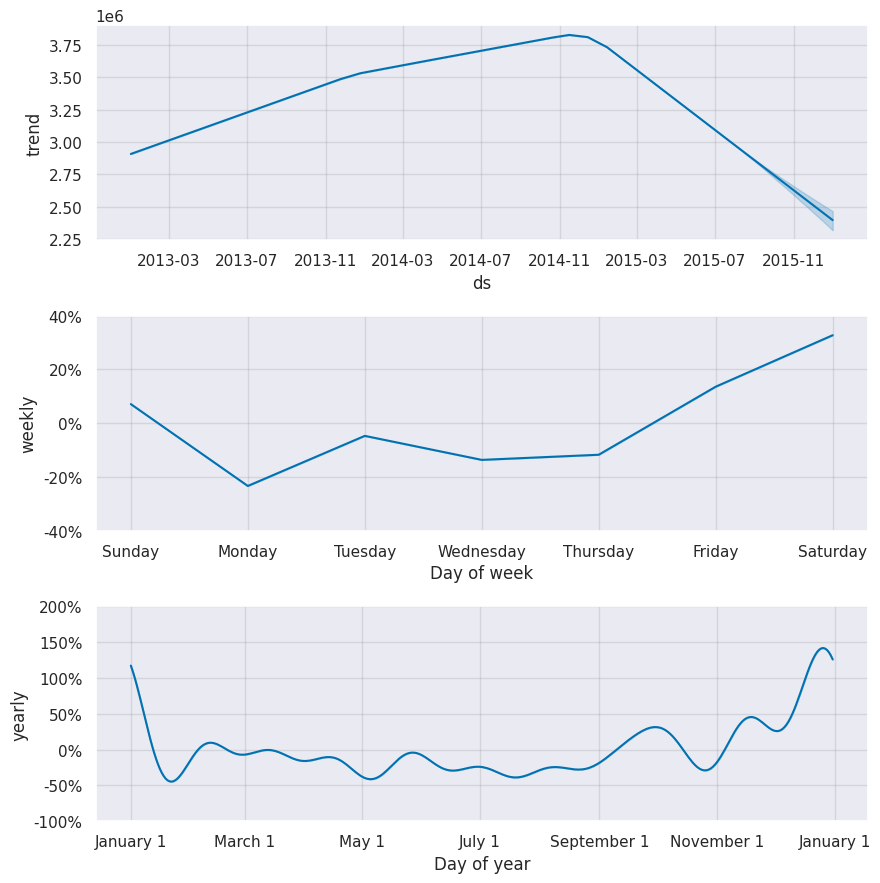

In [71]:
prophet_total_shops_values['model'].plot_components(prophet_total_shops_values['forecast']);

### Cross-Validation

In [72]:
# cross-validation for frequency daily
cv_results = cross_validation(
    model=prophet_total_shops_values['model'],
    initial='365.25 days', # one year
    horizon='31 days', # one month
    period='7 days'
)

  0%|          | 0/77 [00:00<?, ?it/s]

00:28:17 - cmdstanpy - INFO - Chain [1] start processing
00:28:17 - cmdstanpy - INFO - Chain [1] done processing
00:28:18 - cmdstanpy - INFO - Chain [1] start processing
00:28:18 - cmdstanpy - INFO - Chain [1] done processing
00:28:18 - cmdstanpy - INFO - Chain [1] start processing
00:28:18 - cmdstanpy - INFO - Chain [1] done processing
00:28:18 - cmdstanpy - INFO - Chain [1] start processing
00:28:18 - cmdstanpy - INFO - Chain [1] done processing
00:28:18 - cmdstanpy - INFO - Chain [1] start processing
00:28:18 - cmdstanpy - INFO - Chain [1] done processing
00:28:19 - cmdstanpy - INFO - Chain [1] start processing
00:28:19 - cmdstanpy - INFO - Chain [1] done processing
00:28:19 - cmdstanpy - INFO - Chain [1] start processing
00:28:19 - cmdstanpy - INFO - Chain [1] done processing
00:28:19 - cmdstanpy - INFO - Chain [1] start processing
00:28:19 - cmdstanpy - INFO - Chain [1] done processing
00:28:19 - cmdstanpy - INFO - Chain [1] start processing
00:28:20 - cmdstanpy - INFO - Chain [1]

00:28:35 - cmdstanpy - INFO - Chain [1] done processing
00:28:36 - cmdstanpy - INFO - Chain [1] start processing
00:28:36 - cmdstanpy - INFO - Chain [1] done processing
00:28:36 - cmdstanpy - INFO - Chain [1] start processing
00:28:36 - cmdstanpy - INFO - Chain [1] done processing
00:28:36 - cmdstanpy - INFO - Chain [1] start processing
00:28:36 - cmdstanpy - INFO - Chain [1] done processing
00:28:36 - cmdstanpy - INFO - Chain [1] start processing
00:28:36 - cmdstanpy - INFO - Chain [1] done processing


In [73]:
cv_results

ds          yhat    yhat_lower    yhat_upper           y  \
0    2014-01-03  1.342015e+07  1.097556e+07  1.591343e+07  6157385.00   
1    2014-01-04  1.372014e+07  1.149474e+07  1.632905e+07  5692653.00   
2    2014-01-05  1.200881e+07  9.508845e+06  1.444694e+07  5023962.00   
3    2014-01-06  9.763866e+06  7.226877e+06  1.222954e+07  4686706.00   
4    2014-01-07  1.050393e+07  8.033808e+06  1.296680e+07  3847043.00   
...         ...           ...           ...           ...         ...   
2382 2015-07-15  1.581451e+06 -7.452307e+05  3.778181e+06  2143850.50   
2383 2015-07-16  1.618025e+06 -6.100442e+05  3.943785e+06  2098436.75   
2384 2015-07-17  2.404855e+06  1.493670e+05  4.660375e+06  2120300.25   
2385 2015-07-18  2.997321e+06  7.233969e+05  5.389336e+06  2127450.00   
2386 2015-07-19  2.163416e+06  1.030245e+03  4.410473e+06  1884871.50   

         cutoff  
0    2014-01-02  
1    2014-01-02  
2    2014-01-02  
3    2014-01-02  
4    2014-01-02  
...         ...  
2382 2015-06-18  
2383 2015-06-18  
2384 2015-06-18  
2385 2015-06-18  
2386 2015-06-18  

[2387 rows x 6 columns]

In [74]:
df_p = performance_metrics(cv_results)
df_p

horizon           mse          rmse           mae      mape     mdape  \
0   4 days  2.005671e+12  1.416217e+06  9.547763e+05  0.268727  0.213400   
1   5 days  4.621689e+12  2.149811e+06  1.125786e+06  0.321750  0.246580   
2   6 days  5.008448e+12  2.237956e+06  1.198436e+06  0.358960  0.273054   
3   7 days  5.450523e+12  2.334635e+06  1.289077e+06  0.381271  0.293774   
4   8 days  3.533105e+12  1.879656e+06  1.228370e+06  0.383346  0.283996   
5   9 days  3.393559e+12  1.842162e+06  1.244552e+06  0.360049  0.266363   
6  10 days  3.173764e+12  1.781506e+06  1.191037e+06  0.329655  0.224198   
7  11 days  2.382294e+12  1.543468e+06  1.023985e+06  0.304783  0.205246   
8  12 days  4.902762e+12  2.214218e+06  1.167169e+06  0.355770  0.228508   
9  13 days  5.177450e+12  2.275401e+06  1.212554e+06  0.384889  0.274844   
10 14 days  5.437201e+12  2.331781e+06  1.270869e+06  0.392368  0.262090   
11 15 days  3.255611e+12  1.804331e+06  1.197508e+06  0.381536  0.276424   
12 16 days  2.974495e+12  1.724672e+06  1.213999e+06  0.356216  0.263664   
13 17 days  2.701893e+12  1.643744e+06  1.169449e+06  0.325975  0.248494   
14 18 days  2.028320e+12  1.424191e+06  1.006560e+06  0.303325  0.219082   
15 19 days  4.602970e+12  2.145453e+06  1.150203e+06  0.347776  0.235390   
16 20 days  4.968225e+12  2.228952e+06  1.201721e+06  0.377909  0.287074   
17 21 days  5.251552e+12  2.291627e+06  1.266227e+06  0.386581  0.278841   
18 22 days  3.056443e+12  1.748269e+06  1.186531e+06  0.378209  0.269745   
19 23 days  2.731470e+12  1.652716e+06  1.192547e+06  0.352033  0.256068   
20 24 days  2.485760e+12  1.576629e+06  1.148988e+06  0.323202  0.241930   
21 25 days  1.887867e+12  1.373997e+06  9.957435e+05  0.301552  0.224475   
22 26 days  4.544122e+12  2.131695e+06  1.155025e+06  0.350864  0.246399   
23 27 days  4.923368e+12  2.218866e+06  1.207851e+06  0.380932  0.263103   
24 28 days  5.226179e+12  2.286084e+06  1.273571e+06  0.390811  0.262715   
25 29 days  3.061877e+12  1.749822e+06  1.185850e+06  0.379091  0.264813   
26 30 days  2.779552e+12  1.667199e+06  1.198415e+06  0.354051  0.244532   
27 31 days  2.573446e+12  1.604196e+06  1.152312e+06  0.324811  0.236724   

       smape  coverage  
0   0.242152  0.934301  
1   0.291608  0.933919  
2   0.329206  0.914820  
3   0.338417  0.901833  
4   0.322787  0.875095  
5   0.293828  0.883499  
6   0.266236  0.896486  
7   0.259090  0.940031  
8   0.303051  0.909473  
9   0.333578  0.889228  
10  0.335347  0.860199  
11  0.317695  0.855997  
12  0.291424  0.866310  
13  0.267191  0.891138  
14  0.260641  0.931627  
15  0.302083  0.904889  
16  0.333772  0.880825  
17  0.337583  0.859817  
18  0.319517  0.864400  
19  0.290583  0.874332  
20  0.265898  0.891520  
21  0.260835  0.923988  
22  0.304868  0.896104  
23  0.336697  0.872040  
24  0.340254  0.847212  
25  0.319817  0.851413  
26  0.291446  0.869748  
27  0.265617  0.882735

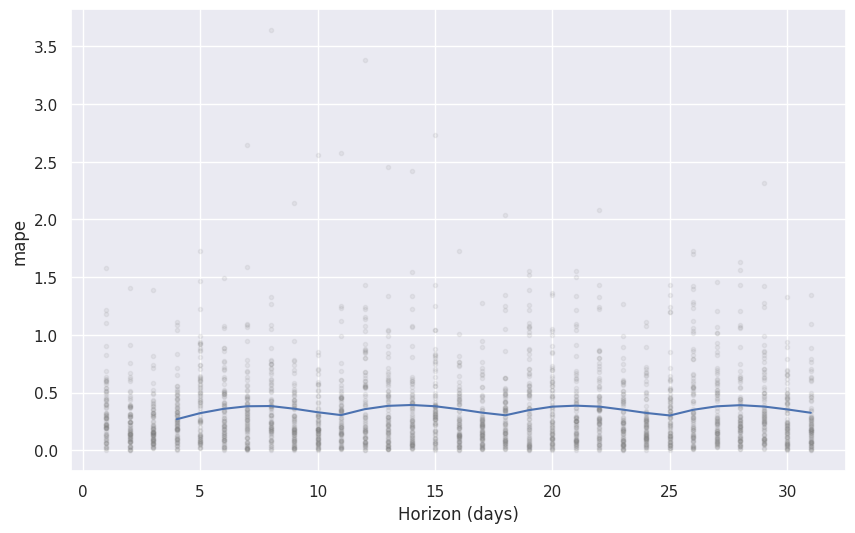

In [75]:
plot_cross_validation_metric(cv_results, metric='mape');

## Total Prediction (no train test split, _"split=1"_)

In [76]:
# total_Shops_Number_sales
prophet_total_shops_sales = prophet_model(
    total_sales,
    split=1
)

# total_Shops_Values
prophet_total_shops_values = prophet_model(
    total_values,
    split=1
)

00:29:22 - cmdstanpy - INFO - Chain [1] start processing
00:29:22 - cmdstanpy - INFO - Chain [1] done processing
00:29:23 - cmdstanpy - INFO - Chain [1] start processing
00:29:23 - cmdstanpy - INFO - Chain [1] done processing


In [77]:
total_sales_pred = get_forecast_data(prophet_total_shops_sales)
total_values_pred = get_forecast_data(prophet_total_shops_values)

### Prediction (sales and values) for "only" the next month, all shops

In [78]:
# SALES
total_sales_pred = total_sales_pred['month']['yhat'][0]
total_sales_pred

2091.6

In [79]:
# VALUES
total_values_pred = total_values_pred['month']['yhat'][0]
total_values_pred

3225336.29

##  Shop Prediction

### Save and Load Models functions

In [80]:
# Save models to file, json(gz) and pickle
def save_model_data(prophet: dict, name: str, save=True):
    """
    Input is the prophet dict return of the prophet_model function.
    name: name of the file to be saved, in .json
    save: save the results in a external file
    Convert Prophet model to json file.
    Convert Data Frame to json file.
    Saves the model and all the data in the local /raw_data/prophet of the project
    Saves only the model in the /prophet_models, local and git repository.
    """
    if not save:
        return "=== MODEL NOT SAVED ==="
    
    print("=== START ===")
    model = {}
    forecast = {}
    train = {}
    horizon = {}
    
    # loop over the ids and features to build a dict with json files
    for id in prophet:
        model[id] = prophet[id]['model']
        forecast[id] = prophet[id]['forecast'].copy()
        train[id] = prophet[id]['train'].copy()
        horizon[id] = prophet[id]['horizon']
        
        # prophet model to json
        model[id] = model_to_json(model[id])
              
        # DF to json
        forecast[id] = forecast[id].to_json()
        train[id] = train[id].to_json()
        # horizon[id] = prophet[id]
    
    # save model and data localy
    with gzip.open('../raw_data/prophet/' + name + '_model.gz', 'wt') as model_dict:
        json.dump(model, model_dict)
        
    with gzip.open('../raw_data/prophet/' + name + '_forecast.gz', 'wt') as forecast_dict:
        json.dump(forecast, forecast_dict)
        
    with gzip.open('../raw_data/prophet/' + name + '_train.gz', 'wt') as train_dict:
        json.dump(train, train_dict)
        
    with open('../raw_data/prophet/' + name + '_horizon.pkl', 'wb') as horizon_pkl:
        pickle.dump(horizon, horizon_pkl)
    
    print("=== MODEL SAVED ===")
    
    return None

In [81]:
# Load models from file
def load_model(file_name: str, path='../raw_data/prophet/') -> dict:    
    path_model = os.path.join(path, file_name + "_model.gz")
    path_forecast = os.path.join(path, file_name + "_forecast.gz")
    path_train = os.path.join(path, file_name + "_train.gz")
    path_horizon = os.path.join(path, file_name + "_horizon.pkl")

    with gzip.open(path_model, 'rt') as mdl:
        model = json.load(mdl)
            
    with gzip.open(path_forecast, 'rt') as frct:
        forecast = json.load(frct)
            
    with gzip.open(path_train, 'rt') as trn:
        train = json.load(trn)
            
    with open(path_horizon, 'rb') as hrzn:
        horizon = pickle.load(hrzn)
        
    
    results = {}
    for id in model:
        prophet_dict = {}
        prophet_dict = {
            'model': fix_model_from_json(model[id]),
            'forecast': pd.read_json(forecast[id]),
            'train': pd.read_json(train[id]),
            'horizon': 62 # horizon[id] HARD CODED! why? no ideia.
        }
        prophet_dict['forecast']['ds'] = pd.to_datetime(prophet_dict['forecast'].ds, unit='ms')
        prophet_dict['train']['ds'] = pd.to_datetime(prophet_dict['train'].ds, unit='ms')
        results[id] = prophet_dict
    
    return results

In [82]:
# Rum prophet or load model result
def run_load_model(df, load=False, model_name="", freq='d'):
    df_id_list = df.columns.to_list()
    prophet_id = {}    
    
    if load:
        print("=== START LOADING ===")
        models = load_model(model_name)
        
        print("=== MODEL LOADED ===")
        
        return models
    
    print("=== Running Prophet Model from Scratch ===")
    
    """
    for id in df_id_list:
        df_ids = df[id].fillna(0)
        prophet_result = prophet_model(
            df=df_ids,
            split=1
        )
        prophet_id[id] = prophet_result
    """
        
    with Pool(cpu_count()) as pool:
        prophet_id = list(pool.map(prophet_model, [df[id].fillna(0) for id in df]))
        
    prophet_id = dict(zip(df_id_list, prophet_id))
    
    print("=== END RUNNING ===")
    
    return prophet_id

### Sales

In [83]:
print(f"LOADED => {LOADED}", f"SAVED => {SAVED}", sep='\n')

LOADED => True
SAVED => False


In [84]:
%%time
# initialize model for each shop id
prophet_shops_id_sales = run_load_model(
    df=shops_sales,
    load=LOADED,
    model_name="prophet_shops_id_sales",
    freq=freq_analysis)

=== START LOADING ===
=== MODEL LOADED ===
CPU times: user 1.44 s, sys: 3.83 ms, total: 1.45 s
Wall time: 1.45 s


In [85]:
# get the prediction for "only" the next month for every shop
shops_id_sales_pred = {}
for shop in prophet_shops_id_sales:
    pred = prophet_shops_id_sales[shop]
    pred = get_forecast_data(pred)
    shops_id_sales_pred[shop] = pred['month']['yhat'][0]

In [454]:
indice = prophet_shops_id_sales['shop_id_0']['forecast']['ds']

In [456]:
prophet_shops_id_sales['shop_id_0']['forecast']['yhat']

0       100.013981
1        98.450560
2       139.398221
3       213.335157
4       278.875358
           ...    
1091      0.037121
1092      0.040992
1093      0.040067
1094      0.063173
1095      0.105722
Name: yhat, Length: 1096, dtype: float64

In [460]:
xxx = pd.DataFrame(index=indice)
for id in prophet_shops_id_sales:
    xxx[id] = list(prophet_shops_id_sales[id]['forecast']['yhat'])
xxx

shop_id_0   shop_id_1  shop_id_2  shop_id_3   shop_id_4  \
ds                                                                     
2013-01-01  100.013981   59.773973  56.182627  44.752471  108.929558   
2013-01-02   98.450560   47.933035  52.945423  43.324141  106.437082   
2013-01-03  139.398221   94.303490  50.001757  43.919410  100.361254   
2013-01-04  213.335157   78.117684  53.793913  47.141501  109.563898   
2013-01-05  278.875358  165.158369  59.392762  59.079829  124.241709   
...                ...         ...        ...        ...         ...   
2015-12-28    0.037121    0.040538  50.991324  30.392498   44.817994   
2015-12-29    0.040992    0.048585  56.992386  31.876633   47.196379   
2015-12-30    0.040067    0.038634  54.858330  31.538814   46.957338   
2015-12-31    0.063173    0.073499  52.981885  32.610448   45.191465   
2016-01-01    0.105722    0.059980  57.635793  35.492247   49.727478   

            shop_id_5   shop_id_6   shop_id_7   shop_id_8  shop_id_9  ...  \
ds                                                                    ...   
2013-01-01  22.969141  198.886500  148.501196   91.898949   7.409979  ...   
2013-01-02  22.258840  182.502230  139.252871   89.658976   8.891889  ...   
2013-01-03  23.034373  181.778399  138.156252   82.652048   5.021880  ...   
2013-01-04  24.868513  196.771999  143.474341   86.224101  -4.698506  ...   
2013-01-05  31.537079  214.575758  167.123297  117.324829  -7.745646  ...   
...               ...         ...         ...         ...        ...  ...   
2015-12-28  63.970820   69.952050   76.745892    0.026806   3.189579  ...   
2015-12-29  64.754605   73.163473   77.945331    0.024533  -0.225034  ...   
2015-12-30  62.774383   68.476892   74.800663    0.024121  -3.696416  ...   
2015-12-31  64.763772   68.903958   75.622943    0.022683   1.946117  ...   
2016-01-01  69.343255   74.415866   79.505145    0.023170  18.149140  ...   

            shop_id_50  shop_id_51  shop_id_52  shop_id_53  shop_id_54  \
ds                                                                       
2013-01-01  169.321295  124.485722   96.187133  114.974531  455.495145   
2013-01-02  166.219470  123.973273   90.516991  109.079967  464.032912   
2013-01-03  168.589625  119.688037   88.999741  107.550436  460.263754   
2013-01-04  175.228603  128.511748   96.912288  111.827710  492.126728   
2013-01-05  217.710426  155.961557  105.415439  140.168597  702.590598   
...                ...         ...         ...         ...         ...   
2015-12-28   40.881155   13.334830   44.371102   51.456624 -150.797657   
2015-12-29   40.563267   13.702581   45.794651   53.604020 -154.464610   
2015-12-30   40.496124   13.767154   43.921676   51.885365 -161.737557   
2015-12-31   41.623921   13.426568   43.895977   52.075750 -164.893635   
2016-01-01   43.654931   14.397133   48.079069   54.786389 -179.557781   

            shop_id_55  shop_id_56  shop_id_57  shop_id_58  shop_id_59  
ds                                                                      
2013-01-01    0.346057  166.198009  -13.241929    8.204927  101.899815  
2013-01-02    0.531181  162.802124   -9.377484    9.649923   97.310034  
2013-01-03    0.696585  164.491667   -5.722574   10.892947   98.644387  
2013-01-04    0.912820  183.846089   -2.611971   12.581591  102.739514  
2013-01-05    1.185945  240.230367    1.015652   16.055393  136.628464  
...                ...         ...         ...         ...         ...  
2015-12-28  229.253947   50.365547  136.470326   94.003596   44.841637  
2015-12-29  272.239887   51.834364  141.250246   92.474367   46.522894  
2015-12-30  280.574590   51.725985  139.251827   91.617462   45.355448  
2015-12-31  277.298824   53.145374  136.473088   89.834378   46.672473  
2016-01-01  295.859327   59.892435  147.139718   91.446060   49.099987  

[1096 rows x 60 columns]

<AxesSubplot: xlabel='ds', ylabel='shop_id_2'>

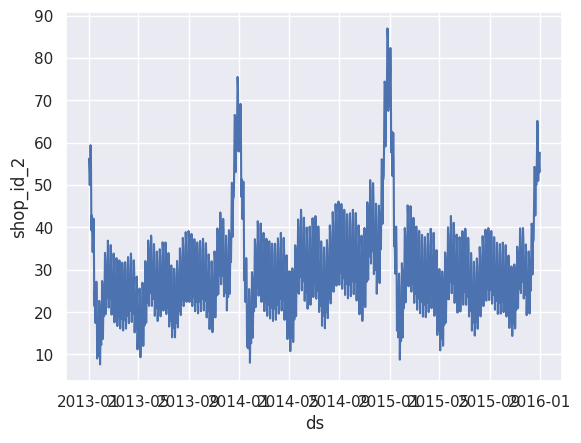

In [462]:
sns.lineplot(xxx['shop_id_2'])

<font size="5"> Total Sales for next month, sun of all shops </font>

In [444]:
all_shops_id_sales_pred = sum(list(shops_id_sales_pred.values()))
all_shops_id_sales_pred

2376.6200000000003

#### Save the data (on _raw\_data_) and model (on _git_) in json file

In [445]:
save_model_data(prophet_shops_id_sales, 'prophet_shops_id_sales', save=SAVED)

'=== MODEL NOT SAVED ==='

#### Plot example

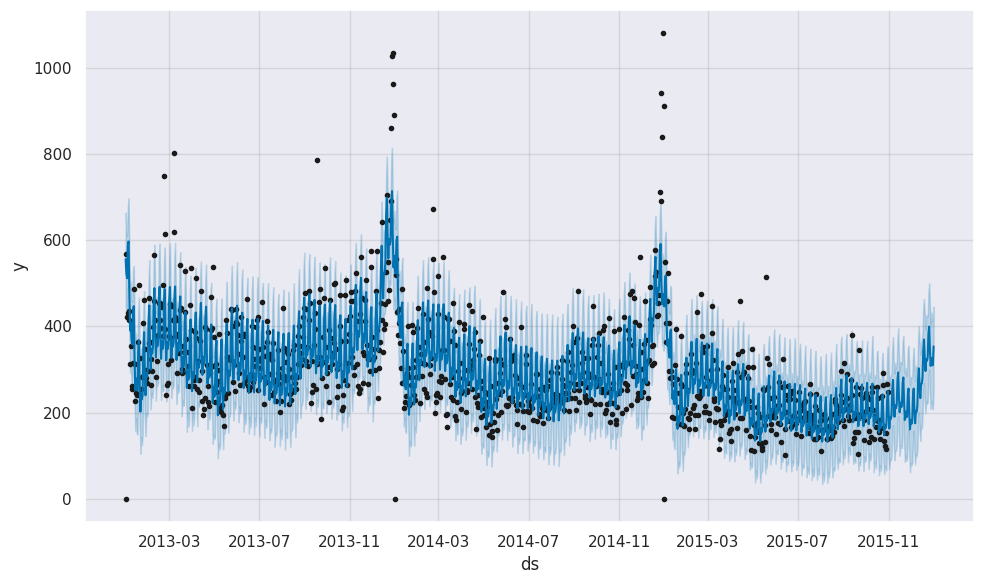

In [88]:
prophet_shops_id_sales['shop_id_31']['model'].plot(prophet_shops_id_sales['shop_id_31']['forecast']);

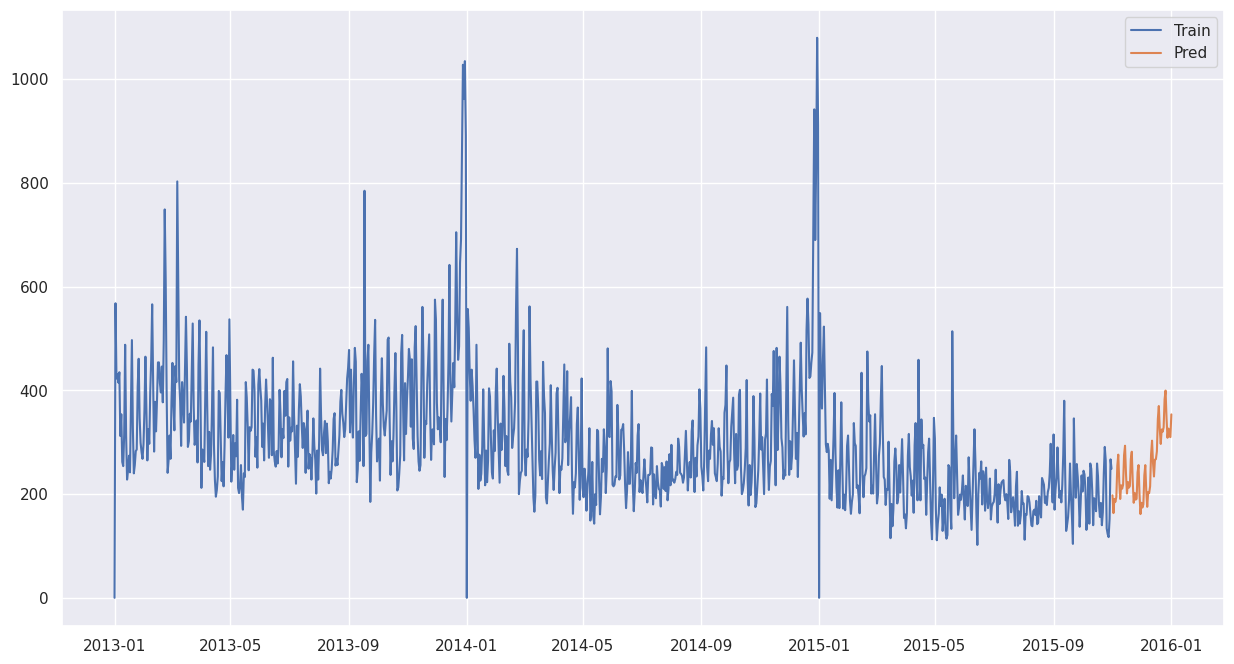

In [89]:
plot_forecast(prophet_shops_id_sales['shop_id_31'], test=False)

### Values

In [90]:
%%time
# initialize model for each shop id
prophet_shops_id_values = run_load_model(
    df=shops_values,
    load=LOADED,
    model_name="prophet_shops_id_values",
    freq=freq_analysis)

=== START LOADING ===
=== MODEL LOADED ===
CPU times: user 1.48 s, sys: 23.2 ms, total: 1.5 s
Wall time: 1.5 s


In [91]:
# get the prediction for "only" the next month for every shop
shops_id_values_pred = {}
for shop in prophet_shops_id_values:
    pred = prophet_shops_id_values[shop]
    pred = get_forecast_data(pred)
    shops_id_values_pred[shop] = pred['month']['yhat'][0]

<font size="5"> Total Values for next month, sun of all shops </font>

In [92]:
all_shops_id_values_pred = sum(list(shops_id_values_pred.values()))
all_shops_id_values_pred

3395246.9699999997

#### Save the data (on raw_data) and model (on git) in json file

In [93]:
save_model_data(prophet_shops_id_values, 'prophet_shops_id_values', save=SAVED)

'=== MODEL NOT SAVED ==='

#### Plot example

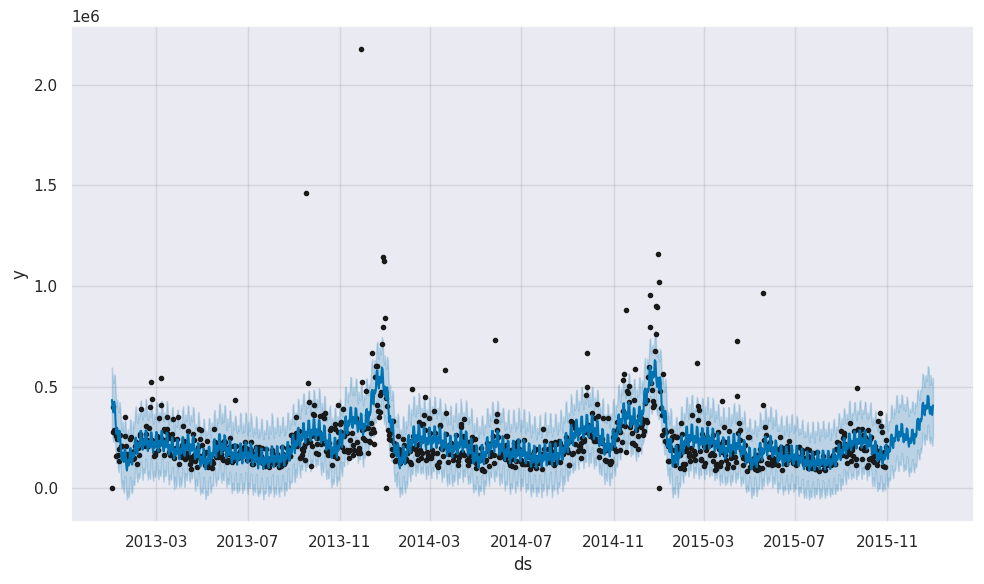

In [94]:
prophet_shops_id_values['shop_id_31']['model'].plot(prophet_shops_id_values['shop_id_31']['forecast']);

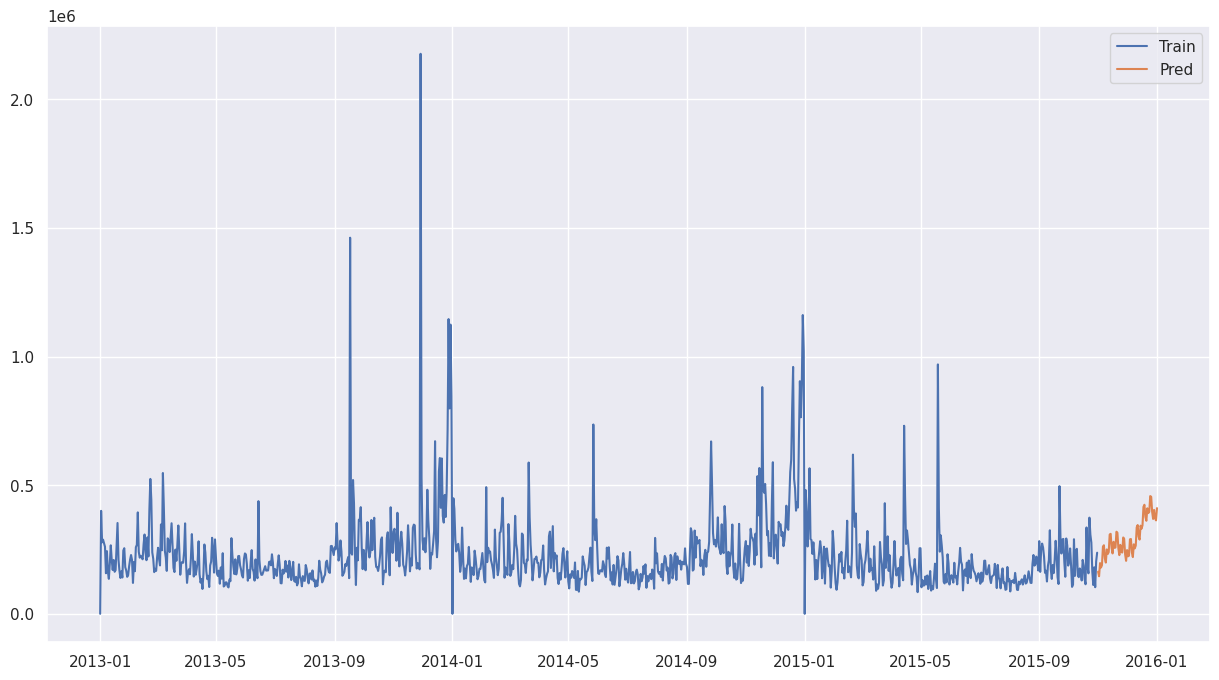

In [95]:
plot_forecast(prophet_shops_id_values['shop_id_31'], test=False)

## Category Prediction

### Sales

In [96]:
%%time
# initialize model for each category id
prophet_cats_id_sales = run_load_model(
    df=cats_sales,
    load=LOADED,
    model_name="prophet_cats_id_sales",
    freq=freq_analysis)

=== START LOADING ===
=== MODEL LOADED ===
CPU times: user 2.08 s, sys: 23.3 ms, total: 2.11 s
Wall time: 2.11 s


In [97]:
# get the prediction for "only" the next month for every category
cats_id_sales_pred = {}
for cat in prophet_cats_id_sales:
    pred = prophet_cats_id_sales[cat]
    pred = get_forecast_data(pred)
    cats_id_sales_pred[cat] = pred['month']['yhat'][0]

<font size="5"> Total Sales for next month, sun of all categories </font>

In [98]:
all_cats_id_sales_pred = sum(list(cats_id_sales_pred.values())).round(2)
all_cats_id_sales_pred

2595.8

#### Save the data (on raw_data) and model (on git) in json file

In [99]:
save_model_data(prophet_cats_id_sales, 'prophet_cats_id_sales', save=SAVED)

'=== MODEL NOT SAVED ==='

#### Plot Example

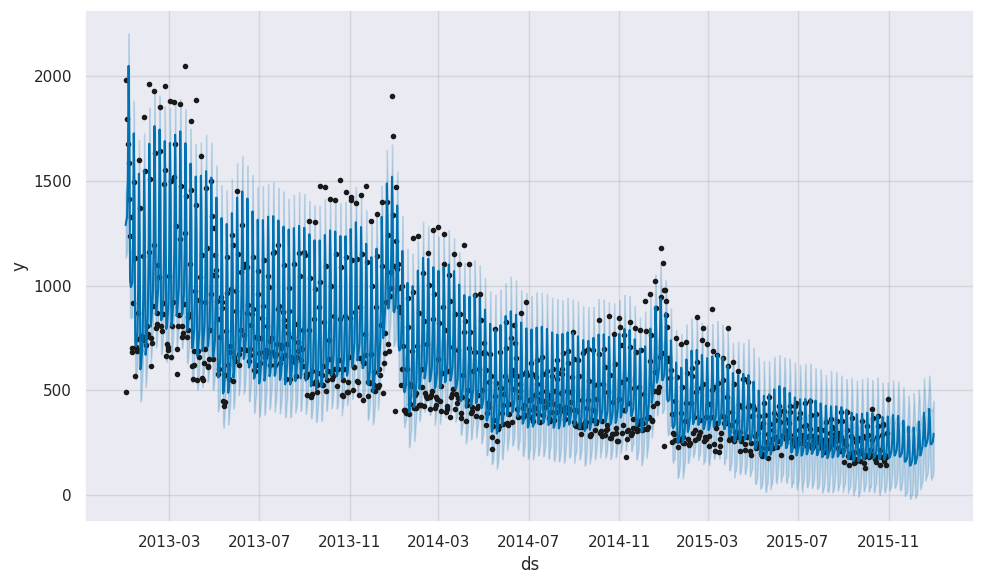

In [100]:
prophet_cats_id_sales['cat_id_40']['model'].plot(prophet_cats_id_sales['cat_id_40']['forecast']);

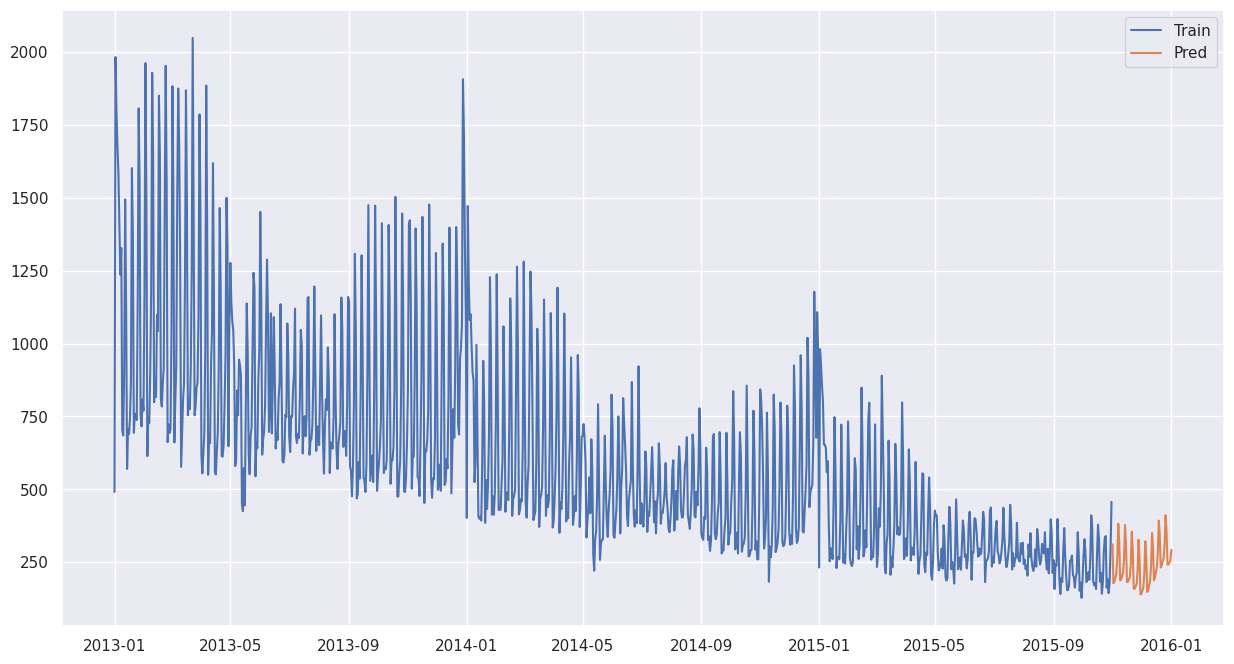

In [101]:
plot_forecast(prophet_cats_id_sales['cat_id_40'], test=False)

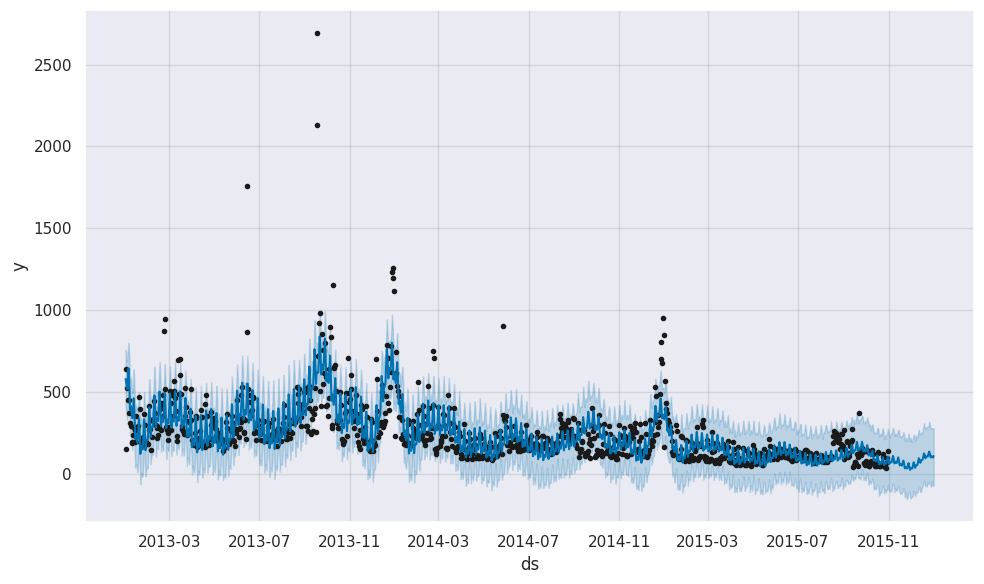

In [102]:
prophet_cats_id_sales['cat_id_19']['model'].plot(prophet_cats_id_sales['cat_id_19']['forecast']);

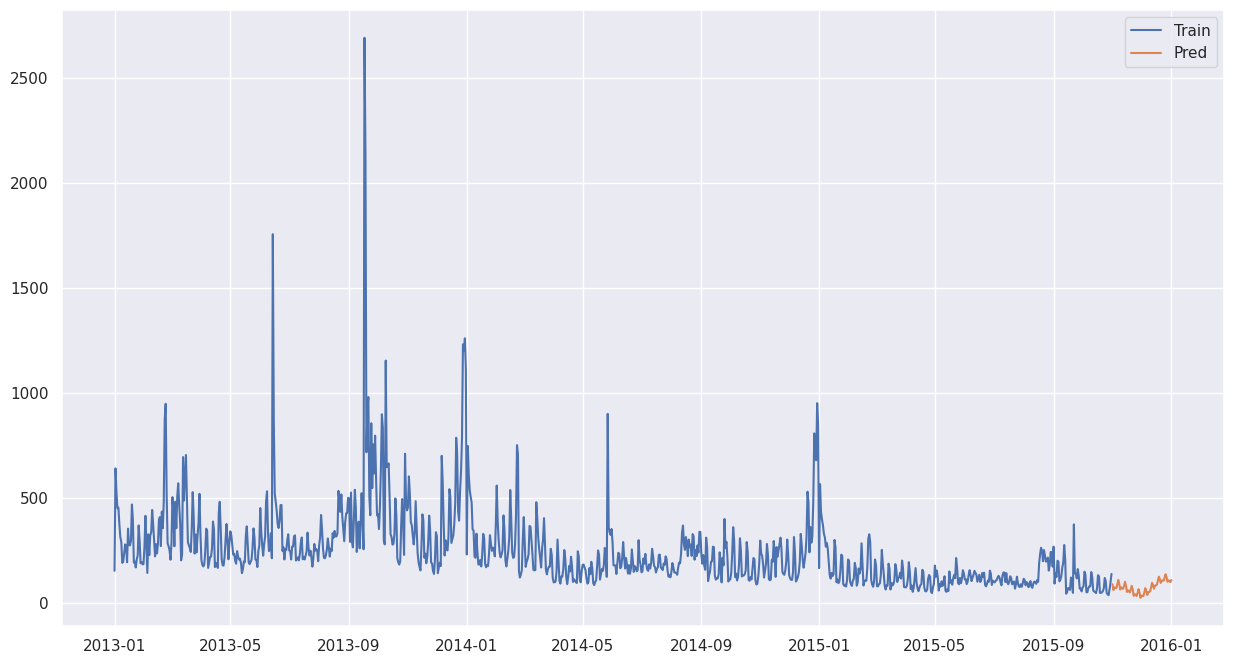

In [103]:
plot_forecast(prophet_cats_id_sales['cat_id_19'], test=False)

### Values

In [104]:
%%time
# initialize model for each category id
prophet_cats_id_values = run_load_model(
    df=cats_values,
    load=LOADED,
    model_name="prophet_cats_id_values",
    freq=freq_analysis)

=== START LOADING ===
=== MODEL LOADED ===
CPU times: user 2.09 s, sys: 31.1 ms, total: 2.12 s
Wall time: 2.12 s


In [105]:
# get the prediction for "only" the next month for every category
cats_id_values_pred = {}
for cat in prophet_cats_id_values:
    pred = prophet_cats_id_values[cat]
    pred = get_forecast_data(pred)
    cats_id_values_pred[cat] = pred['month']['yhat'][0]

<font size="5"> Total Values for next month, sun of all categories </font>

In [106]:
all_cats_id_values_pred = sum(list(cats_id_values_pred.values())).round(2)
all_cats_id_values_pred

3577287.16

#### Save the data (on raw_data) and model (on git) in json file

In [107]:
save_model_data(prophet_cats_id_values, 'prophet_cats_id_values', save=SAVED)

'=== MODEL NOT SAVED ==='

#### Plot Example

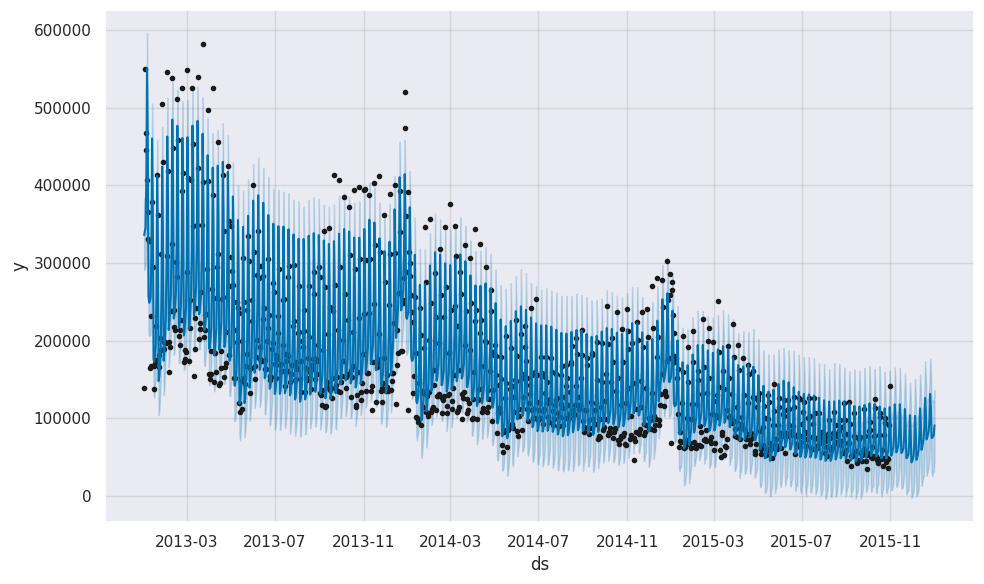

In [108]:
prophet_cats_id_values['cat_id_40']['model'].plot(prophet_cats_id_values['cat_id_40']['forecast']);

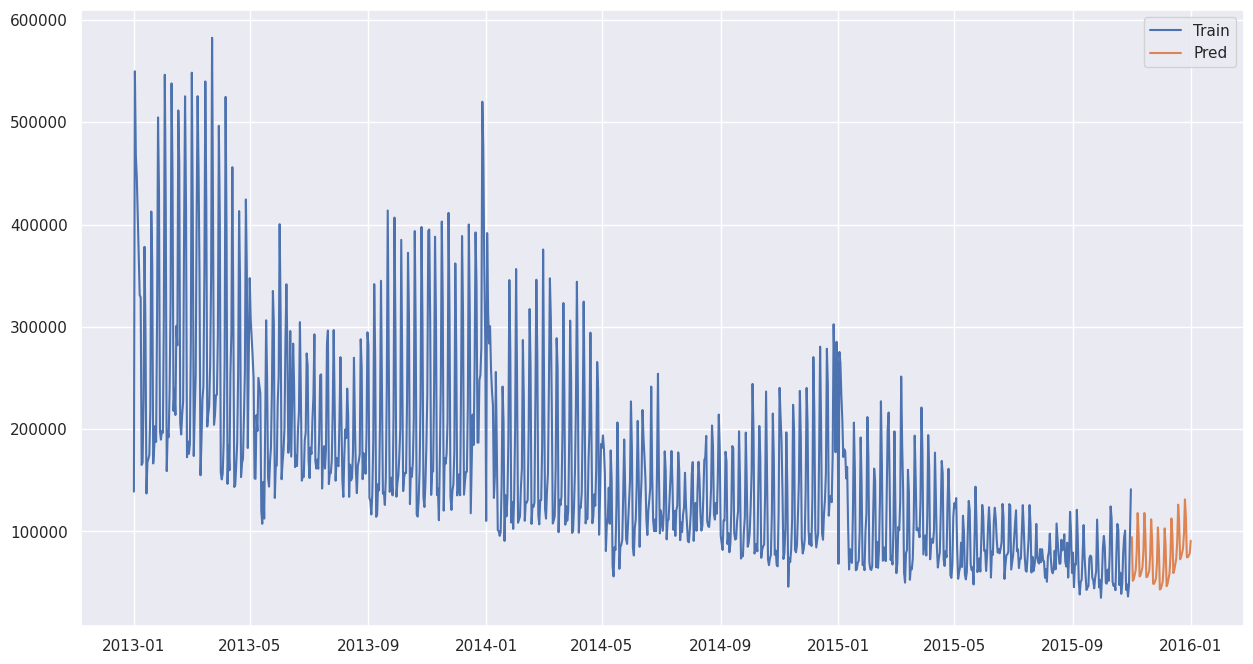

In [109]:
plot_forecast(prophet_cats_id_values['cat_id_40'], test=False)

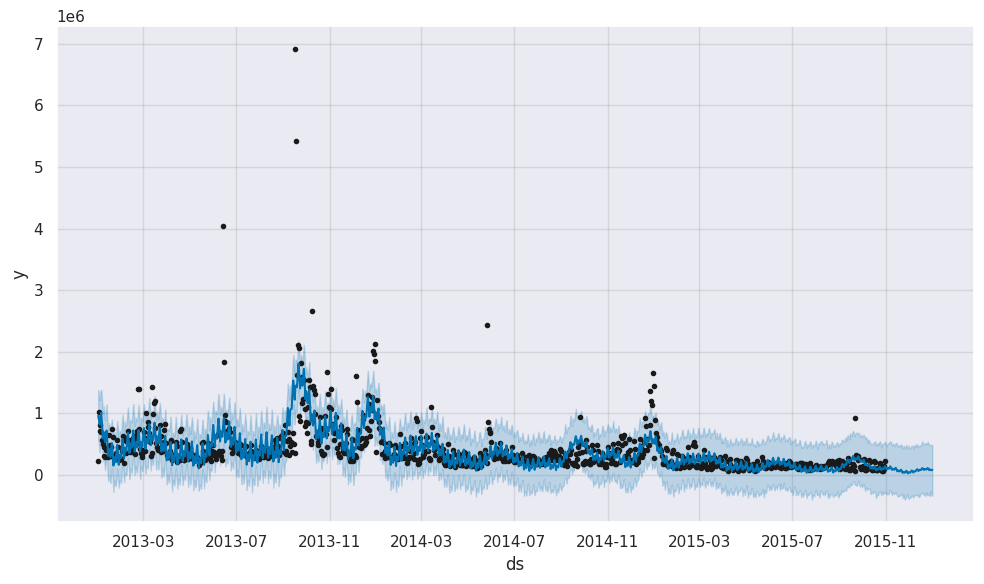

In [110]:
prophet_cats_id_values['cat_id_19']['model'].plot(prophet_cats_id_values['cat_id_19']['forecast']);

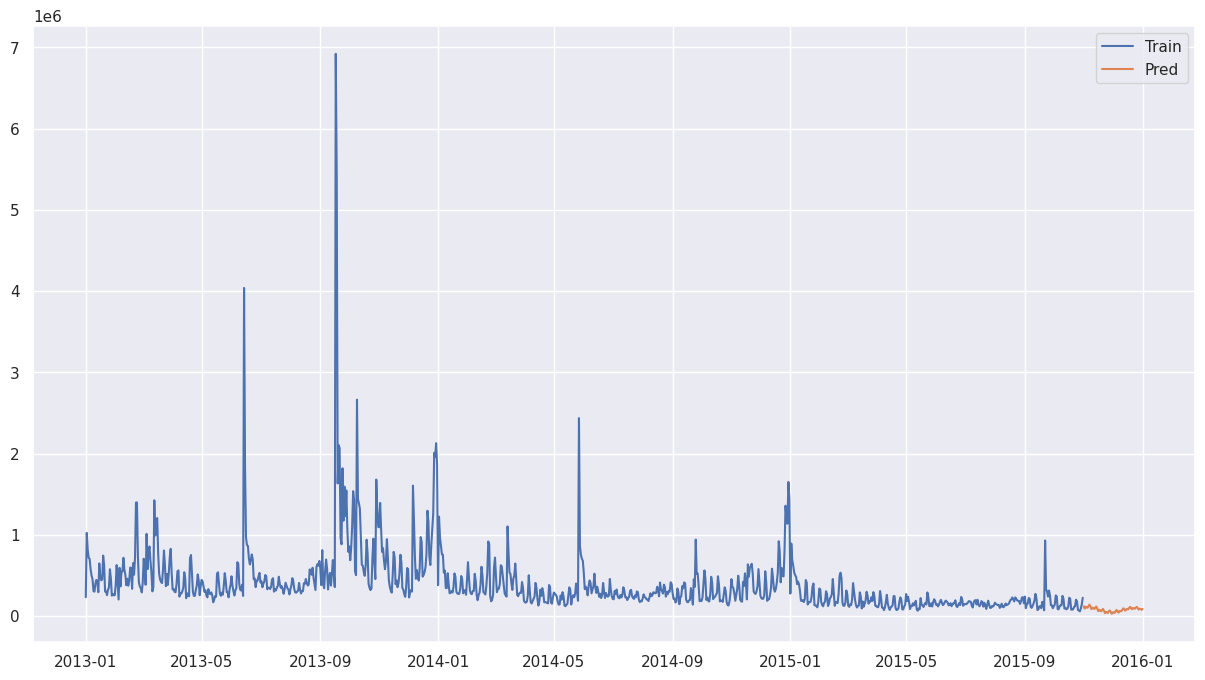

In [111]:
plot_forecast(prophet_cats_id_values['cat_id_19'], test=False)

## Item Prediction

### Sales

In [112]:
%%time
# initialize model for each category id
prophet_items_id_sales = run_load_model(
    df=items_sales,
    load=LOADED,
    model_name="prophet_items_id_sales",
    freq=freq_analysis)

=== START LOADING ===
=== MODEL LOADED ===
CPU times: user 1min 56s, sys: 2.43 s, total: 1min 59s
Wall time: 1min 59s


In [139]:
# get the prediction for "only" the next month for every item
items_id_sales_pred = {}
for item in prophet_items_id_sales:
    pred = prophet_items_id_sales[item]
    pred = get_forecast_data(pred)
    items_id_sales_pred[item] = pred['month']['yhat'][0]

In [144]:
items_id_sales_pred

{'30': 0.02,
 '31': 0.49,
 '32': 0.9,
 '33': 0.18,
 '38': 0.13,
 '42': 0.0,
 '45': 0.09,
 '51': 0.03,
 '53': 0.08,
 '57': 0.1,
 '59': 0.07,
 '62': -0.05,
 '64': -0.03,
 '67': 0.36,
 '69': 0.57,
 '70': 0.41,
 '72': -0.01,
 '76': -0.04,
 '80': 0.0,
 '88': -0.01,
 '91': 0.27,
 '93': 0.1,
 '109': 0.06,
 '138': -0.01,
 '149': 0.11,
 '153': 0.03,
 '154': 0.08,
 '166': 0.01,
 '180': 0.02,
 '202': 0.07,
 '205': 0.12,
 '213': 0.1,
 '226': 0.03,
 '234': 0.16,
 '248': 0.28,
 '253': 0.03,
 '259': 0.04,
 '269': 0.12,
 '308': 0.05,
 '313': 0.03,
 '315': 0.28,
 '325': 0.1,
 '342': 0.0,
 '353': 0.05,
 '356': 0.05,
 '388': 0.05,
 '407': 0.02,
 '408': 0.0,
 '413': 0.07,
 '421': -0.01,
 '445': 0.02,
 '448': 0.04,
 '464': 0.74,
 '473': 0.24,
 '474': 0.02,
 '477': 0.01,
 '478': 0.01,
 '482': 1.05,
 '486': 6.36,
 '491': 0.23,
 '492': 3.65,
 '494': 0.07,
 '496': 0.04,
 '502': 0.05,
 '503': 0.11,
 '504': 0.08,
 '505': 0.03,
 '508': 0.0,
 '515': 0.15,
 '521': 0.01,
 '524': 0.0,
 '528': -0.0,
 '536': 0.03,
 '53

<font size="5"> Total Sales for next month, sun of all items </font>

In [140]:
all_items_id_sales_pred = sum(list(items_id_sales_pred.values())).round(2)
all_items_id_sales_pred

4097.24

#### Save the data (on raw_data) and model (on git) in json file

In [115]:
save_model_data(prophet_items_id_sales, 'prophet_items_id_sales', save=SAVED)

'=== MODEL NOT SAVED ==='

#### Plot Example

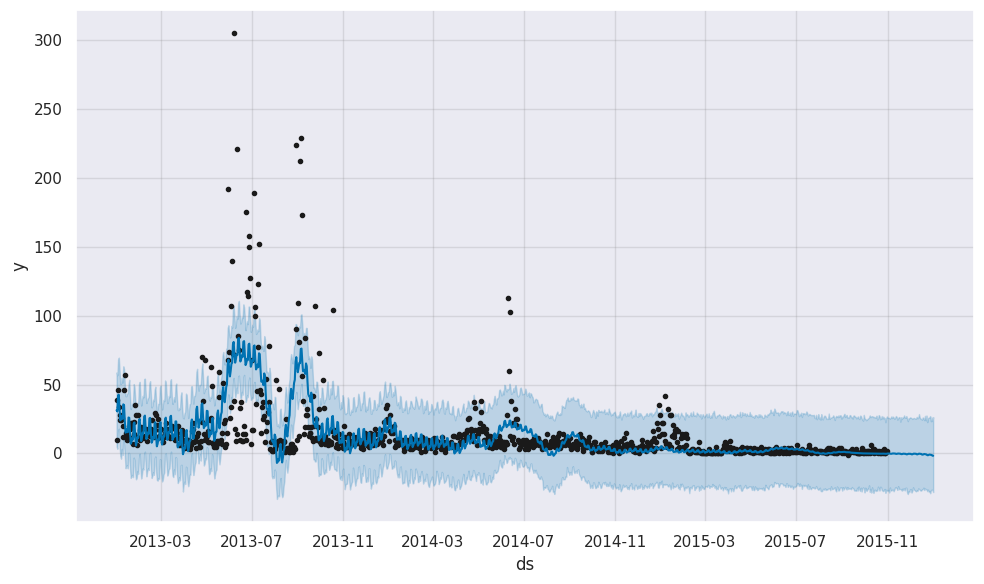

In [116]:
prophet_items_id_sales['2808']['model'].plot(prophet_items_id_sales['2808']['forecast']);

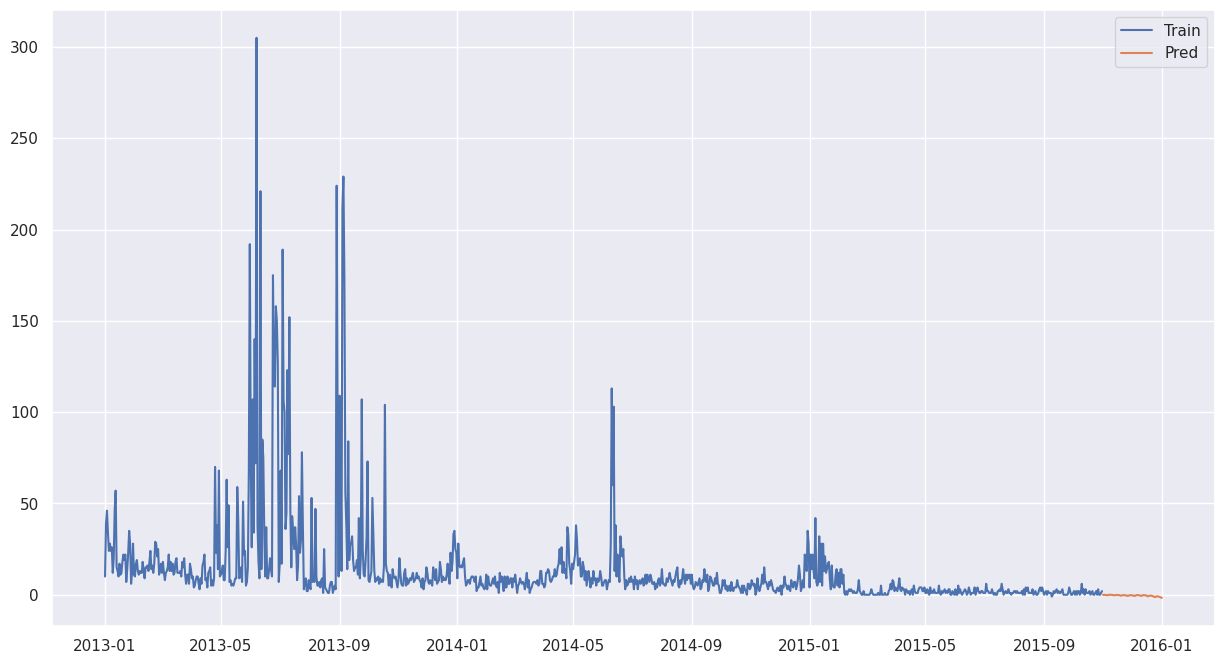

In [117]:
plot_forecast(prophet_items_id_sales['2808'], test=False)

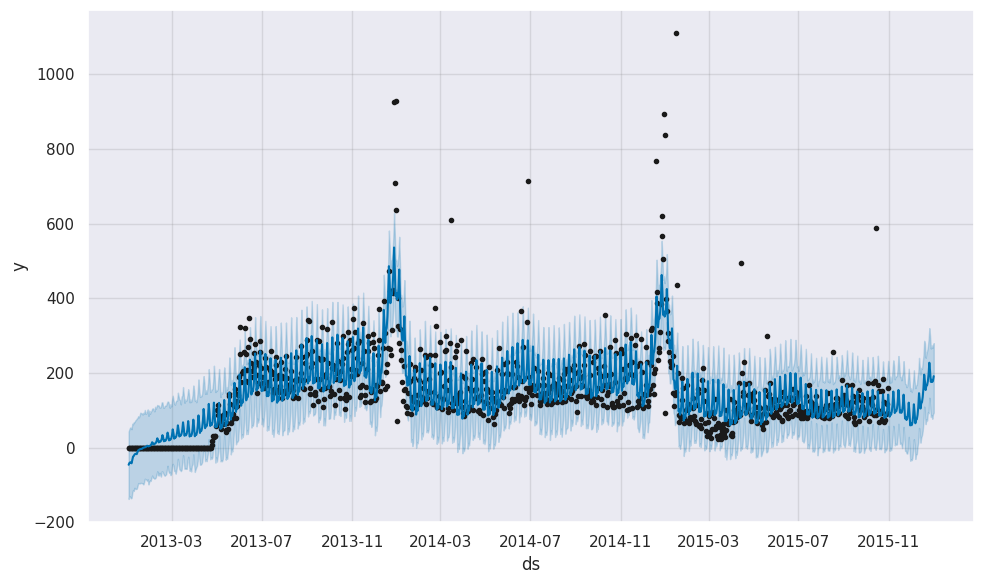

In [118]:
prophet_items_id_sales['20949']['model'].plot(prophet_items_id_sales['20949']['forecast']);

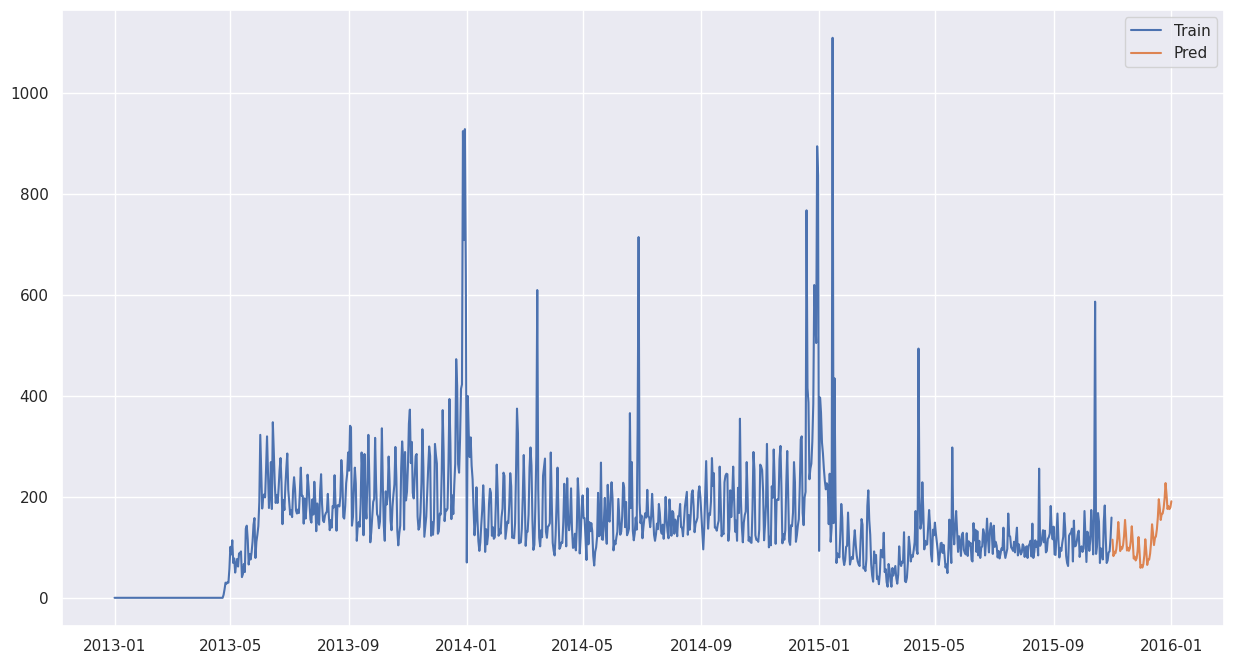

In [119]:
plot_forecast(prophet_items_id_sales['20949'], test=False)

### Values

In [ ]:
%%time
# initialize model for each category id
prophet_items_id_values = run_load_model(
    df=items_values,
    load=False,
    model_name="prophet_items_id_values",
    freq=freq_analysis)

<font size="5"> Total Sales for next month, sun of all items </font>

#### Save the data (on raw_data) and model (on git) in json file

#### Plot Example

## Categories by Shop Prediction

### Sales

In [167]:
%%time
# initialize model for each category id
prophet_cats_shops_id_sales = run_load_model(
    df=cats_shops_sales,
    load=LOADED,
    model_name="prophet_cats_shops_id_sales",
    freq=freq_analysis)

=== START LOADING ===
=== MODEL LOADED ===
CPU times: user 52.7 s, sys: 607 ms, total: 53.3 s
Wall time: 53.3 s


In [168]:
# get the prediction for "only" the next month for every item
cats_shops_id_sales_pred = {}
for item in prophet_cats_shops_id_sales:
    pred = prophet_cats_shops_id_sales[item]
    pred = get_forecast_data(pred)
    cats_shops_id_sales_pred[item] = pred['month']['yhat'][0]

In [169]:
cats_shops_id_sales_pred

{'2-2': 0.04,
 '2-3': 0.32,
 '2-5': 0.01,
 '2-6': 0.1,
 '2-7': 0.16,
 '2-11': 0.0,
 '2-12': 0.0,
 '2-15': 0.04,
 '2-16': 0.0,
 '2-19': 2.58,
 '2-20': 7.67,
 '2-21': 0.14,
 '2-22': 0.19,
 '2-23': 2.13,
 '2-24': 1.1,
 '2-25': 0.3,
 '2-28': 4.15,
 '2-29': 0.24,
 '2-30': 2.59,
 '2-33': 0.11,
 '2-35': 0.24,
 '2-37': 0.94,
 '2-38': 0.76,
 '2-40': 1.27,
 '2-41': 0.04,
 '2-42': 0.48,
 '2-43': 0.0,
 '2-47': 1.83,
 '2-49': -0.0,
 '2-55': -0.11,
 '2-56': 0.08,
 '2-57': -0.0,
 '2-58': 0.01,
 '2-61': 0.11,
 '2-62': 0.0,
 '2-63': 1.02,
 '2-64': 0.41,
 '2-65': 0.42,
 '2-67': 0.04,
 '2-69': 0.45,
 '2-70': 1.52,
 '2-71': -0.0,
 '2-72': 1.38,
 '2-73': 0.07,
 '2-75': 0.26,
 '2-77': 0.0,
 '2-79': 0.18,
 '2-83': 0.0,
 '3-2': 0.23,
 '3-3': 0.56,
 '3-5': 0.0,
 '3-6': 0.2,
 '3-7': 0.13,
 '3-11': 0.01,
 '3-12': 0.09,
 '3-15': 0.01,
 '3-16': 0.0,
 '3-19': 1.22,
 '3-20': 4.86,
 '3-21': 0.18,
 '3-22': 0.1,
 '3-23': 1.53,
 '3-24': 1.06,
 '3-25': 0.07,
 '3-28': 2.03,
 '3-29': 0.01,
 '3-30': 4.36,
 '3-33': 0.25,
 '3

<font size="5"> Total Sales for next month, sun of all items </font>

In [170]:
all_cats_shops_id_sales_pred = sum(list(cats_shops_id_sales_pred.values())).round(2)
all_cats_shops_id_sales_pred

2792.99

#### Save the data (on raw_data) and model (on git) in json file

In [154]:
new_keys = [str(key[0])+"-"+str(key[1]) for key in prophet_cats_shops_id_sales.keys()]
prophet_cats_shops_id_sales_new = dict(zip(new_keys, prophet_cats_shops_id_sales.values()))

In [166]:
save_model_data(prophet_cats_shops_id_sales_new, 'prophet_cats_shops_id_sales', save=SAVED)

'=== MODEL NOT SAVED ==='

#### Plot Example

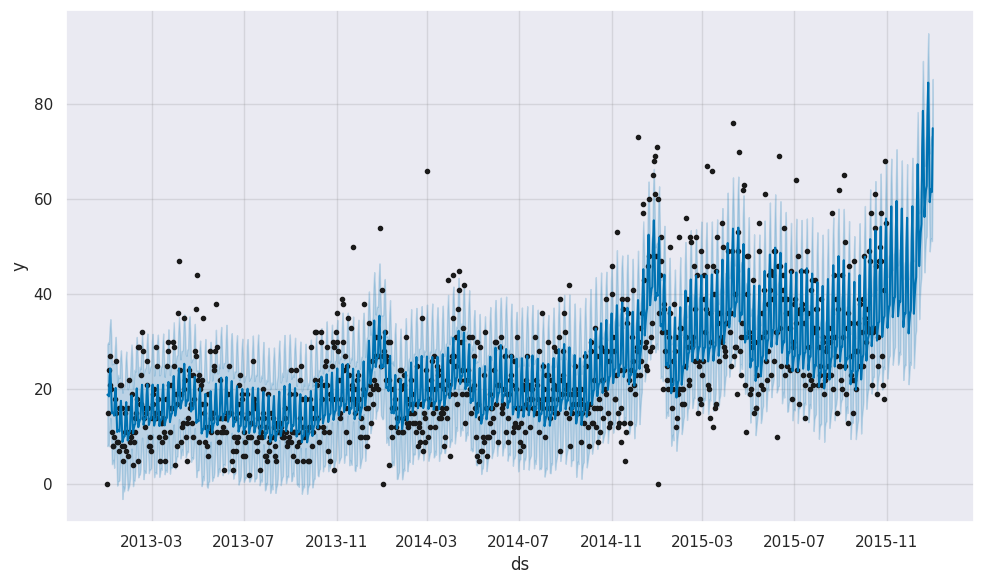

In [172]:
prophet_cats_shops_id_sales_new['31-40']['model'].plot(prophet_cats_shops_id_sales_new['31-40']['forecast']);

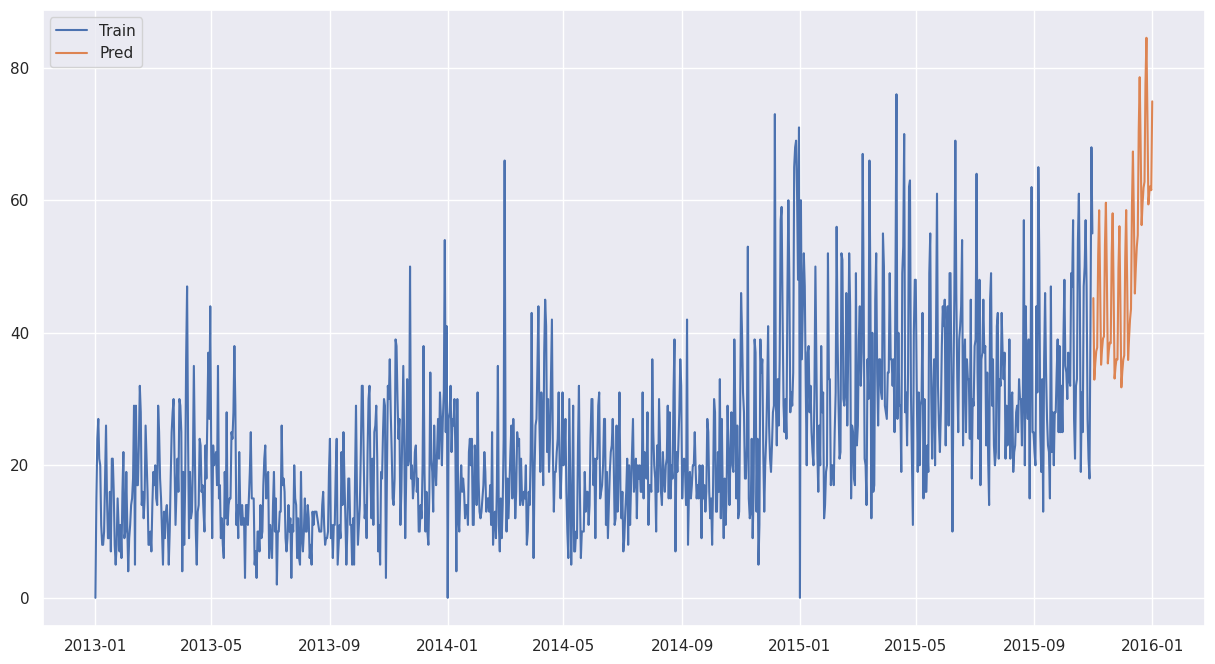

In [173]:
plot_forecast(prophet_cats_shops_id_sales_new['31-40'], test=False)

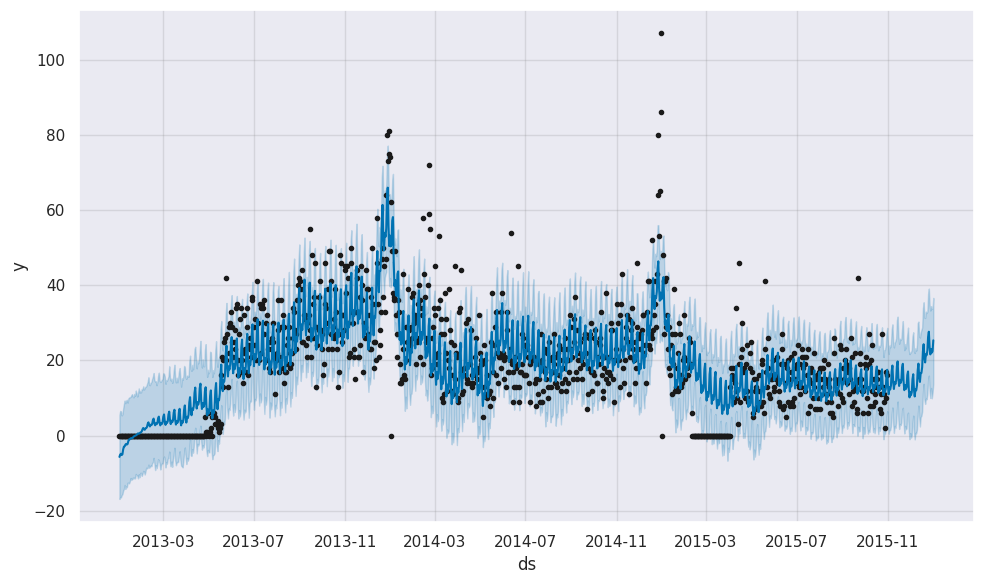

In [174]:
prophet_cats_shops_id_sales_new['31-71']['model'].plot(prophet_cats_shops_id_sales_new['31-71']['forecast']);

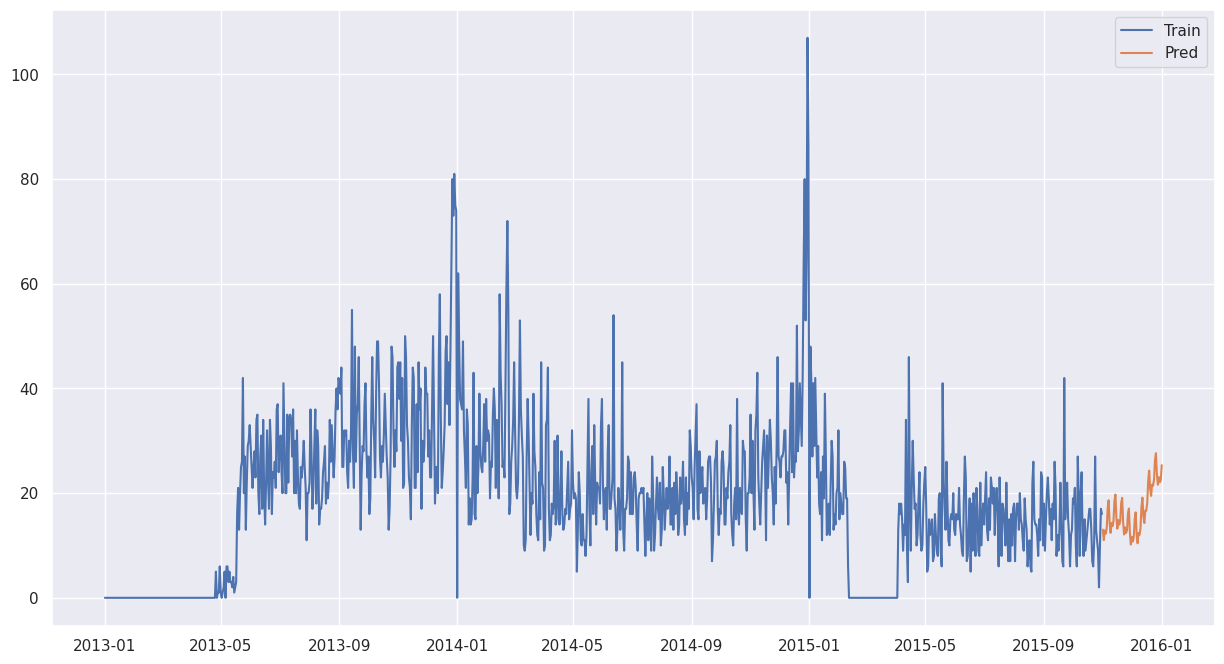

In [175]:
plot_forecast(prophet_cats_shops_id_sales_new['31-71'], test=False)

### Values

<font size="5"> Total Sales for next month, sun of all items </font>

#### Save the data (on raw_data) and model (on git) in json file

#### Plot Example

# Predictions
___

## For all Data Set, the sum of Shops and Category ids

In [181]:
pred_df = pd.DataFrame(
    {'total':[total_sales_pred, total_values_pred],
     'shops_all_id':[all_shops_id_sales_pred, all_shops_id_values_pred],
     'cats_all_id':[all_cats_id_sales_pred, all_cats_id_values_pred],
     'items_all_id':[all_items_id_sales_pred, 0],
     'cats_shps_id':[all_cats_shops_id_sales_pred, 0]
    },
    
    
    index=['sales', 'values']
)
pred_df

total  shops_all_id  cats_all_id  items_all_id  cats_shps_id
sales      2091.60       2376.62      2595.80       4097.24       2792.99
values  3225336.29    3395246.97   3577287.16          0.00          0.00

## Tables for predicted sales and values of all Models

In [248]:
pred_shops_id_sales_df = pd.DataFrame(shops_id_sales_pred, index=[0])
pred_shops_id_values_df = pd.DataFrame(shops_id_values_pred, index=[0])
pred_cats_id_sales_df = pd.DataFrame(cats_id_sales_pred, index=[0])
pred_cats_id_values_df = pd.DataFrame(cats_id_values_pred, index=[0])

In [249]:
pred_items_id_sales_df = pd.DataFrame(items_id_sales_pred, index=[0])
pred_cats_shops_id_sales_df = pd.DataFrame(cats_shops_id_sales_pred, index=[0])

In [251]:
shops_pred = pred_shops_id_sales_df.T
shops_pred['shop_id'] = [int(id.split("_")[2]) for id in shops_pred.index]
shops_pred.rename(columns={0: 'shops_n_sales'}, inplace=True)
shops_pred

shops_n_sales  shop_id
shop_id_0            0.03        0
shop_id_1            0.02        1
shop_id_2           28.50        2
shop_id_3           21.97        3
shop_id_4           27.82        4
shop_id_5           34.00        5
shop_id_6           54.26        6
shop_id_7           42.67        7
shop_id_8           -0.00        8
shop_id_9           12.74        9
shop_id_10          14.99       10
shop_id_11           0.17       11
shop_id_12         294.90       12
shop_id_13          -0.49       13
shop_id_14          38.19       14
shop_id_15          41.01       15
shop_id_16          30.98       16
shop_id_17          -6.69       17
shop_id_18          42.24       18
shop_id_19          48.51       19
shop_id_20          17.87       20
shop_id_21          64.87       21
shop_id_22          46.28       22
shop_id_23          -0.01       23
shop_id_24          37.11       24
shop_id_25         190.29       25
shop_id_26          41.92       26
shop_id_27         -19.22       27
shop_id_28          90.39       28
shop_id_29         -15.27       29
shop_id_30          -7.18       30
shop_id_31         220.09       31
shop_id_32          -0.00       32
shop_id_33          -5.53       33
shop_id_34          14.77       34
shop_id_35          48.07       35
shop_id_36          17.97       36
shop_id_37          36.07       37
shop_id_38          45.15       38
shop_id_39          32.89       39
shop_id_40          -0.44       40
shop_id_41          24.57       41
shop_id_42         161.48       42
shop_id_43         -11.29       43
shop_id_44          22.36       44
shop_id_45          20.46       45
shop_id_46          47.26       46
shop_id_47          68.66       47
shop_id_48          32.84       48
shop_id_49          22.79       49
shop_id_50          26.66       50
shop_id_51          11.48       51
shop_id_52          29.88       52
shop_id_53          34.32       53
shop_id_54         -67.05       54
shop_id_55         189.39       55
shop_id_56          36.57       56
shop_id_57          67.06       57
shop_id_58          42.55       58
shop_id_59          34.72       59

In [260]:
shops_pred.to_csv('../raw_data/prophet/shops_pred.csv')

In [252]:
cat_pred = pred_cats_id_sales_df.T
cat_pred['cat_id'] = [int(id.split("_")[2]) for id in cat_pred.index]
cat_pred.rename(columns={0: 'cats_n_sales'}, inplace=True)
cat_pred

cats_n_sales  cat_id
cat_id_0           0.00       0
cat_id_1           0.00       1
cat_id_2           1.73       2
cat_id_3          29.25       3
cat_id_4          -0.29       4
...                 ...     ...
cat_id_79         14.83      79
cat_id_80         84.94      80
cat_id_81         -0.02      81
cat_id_82         -0.30      82
cat_id_83          6.25      83

[84 rows x 2 columns]

In [261]:
cat_pred.to_csv('../raw_data/prophet/cat_pred.csv')

In [281]:
items_pred = pred_items_id_sales_df.T
items_pred['item_id'] = [(id) for id in items_pred.index]
items_pred['item_id'] = items_pred['item_id'].astype('int64')
items_pred.rename(columns={0: 'items_n_sales'}, inplace=True)
items_pred

items_n_sales  item_id
30              0.02       30
31              0.49       31
32              0.90       32
33              0.18       33
38              0.13       38
...              ...      ...
22162           0.38    22162
22163           0.68    22163
22164          -0.01    22164
22166           0.40    22166
22167           0.92    22167

[4716 rows x 2 columns]

In [262]:
items_pred.to_csv('../raw_data/prophet/items_pred.csv')

In [250]:
cats_shops_pred = pred_cats_shops_id_sales_df.T
cats_shops_pred['shop_id'] = [int(id.split("-")[0]) for id in cats_shops_pred.index]
cats_shops_pred['cat_id'] = [int(id.split("-")[1]) for id in cats_shops_pred.index]
cats_shops_pred.rename(columns={0: 'cat_shops_n_sales'}, inplace=True)
cats_shops_pred

cat_shops_n_sales  shop_id  cat_id
2-2                 0.04        2       2
2-3                 0.32        2       3
2-5                 0.01        2       5
2-6                 0.10        2       6
2-7                 0.16        2       7
...                  ...      ...     ...
59-73               0.04       59      73
59-75               0.46       59      75
59-77               0.00       59      77
59-79               0.65       59      79
59-83               0.29       59      83

[2008 rows x 3 columns]

In [263]:
cats_shops_pred.to_csv('../raw_data/prophet/cats_shops_pred.csv')

### Plots

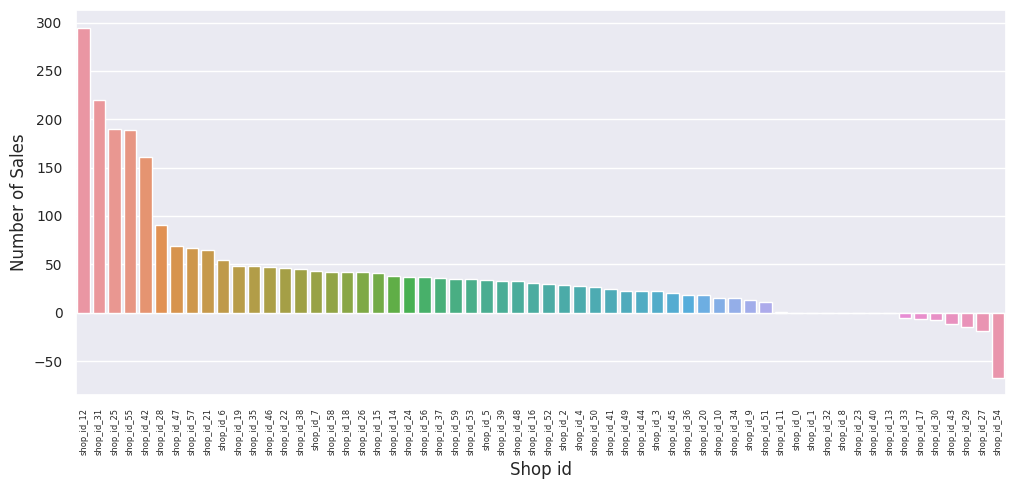

In [189]:
bar_plot_func(pred_shops_id_sales_df, "Shop id", "Number of Sales")

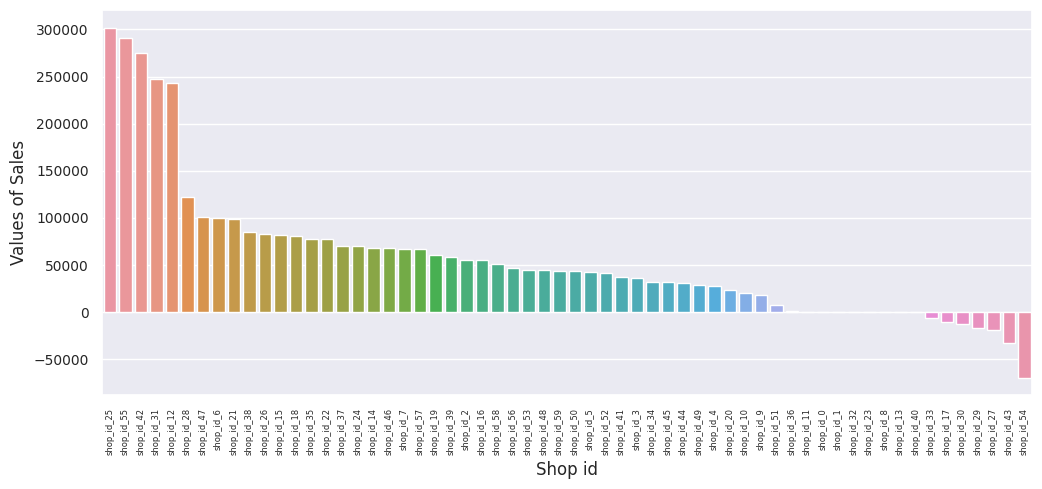

In [187]:
bar_plot_func(pred_shops_id_values_df, "Shop id", "Values of Sales")

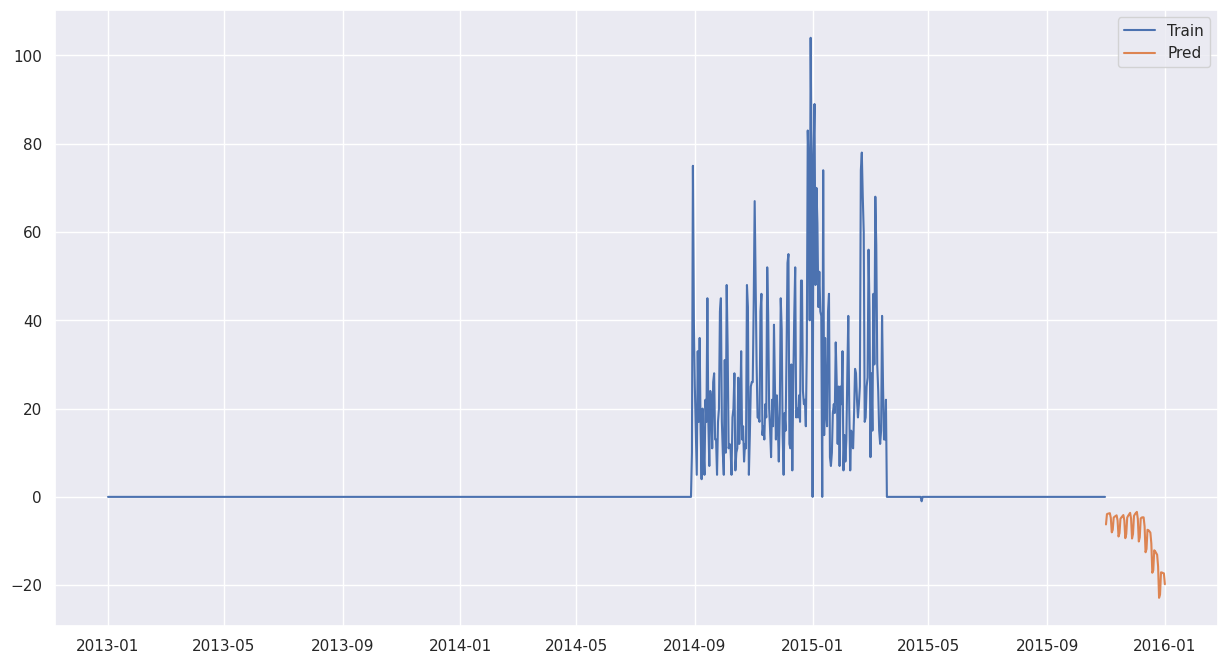

In [190]:
plot_forecast(prophet_shops_id_sales['shop_id_33'], test=False)

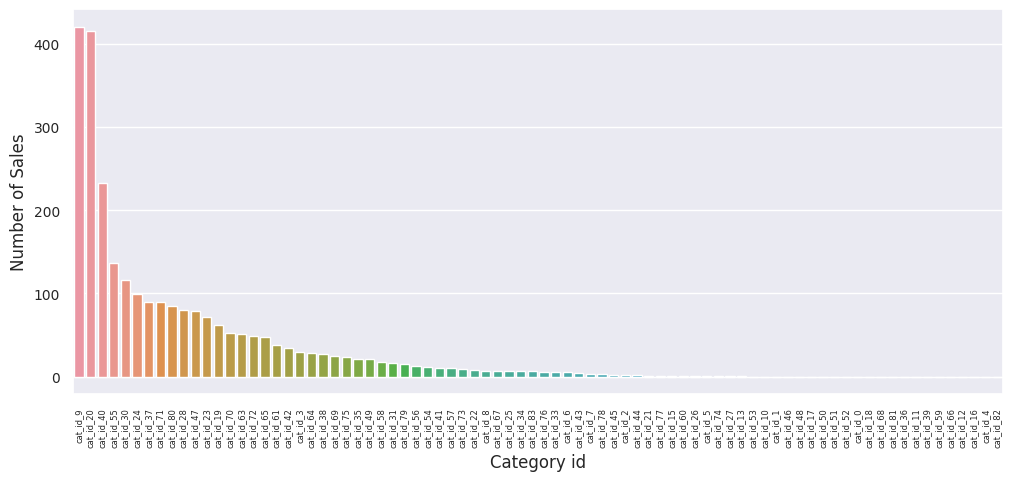

In [191]:
bar_plot_func(pred_cats_id_sales_df, "Category id", "Number of Sales")

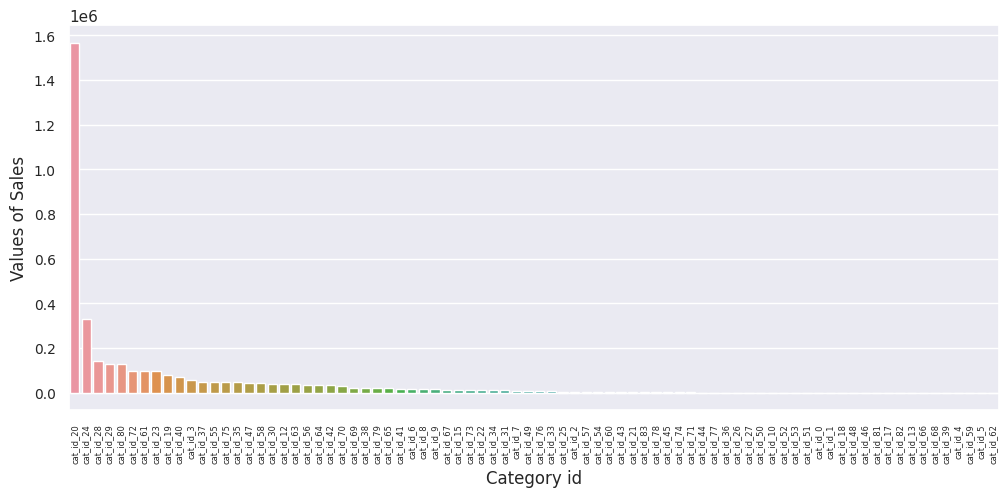

In [192]:
bar_plot_func(pred_cats_id_values_df, "Category id", "Values of Sales")

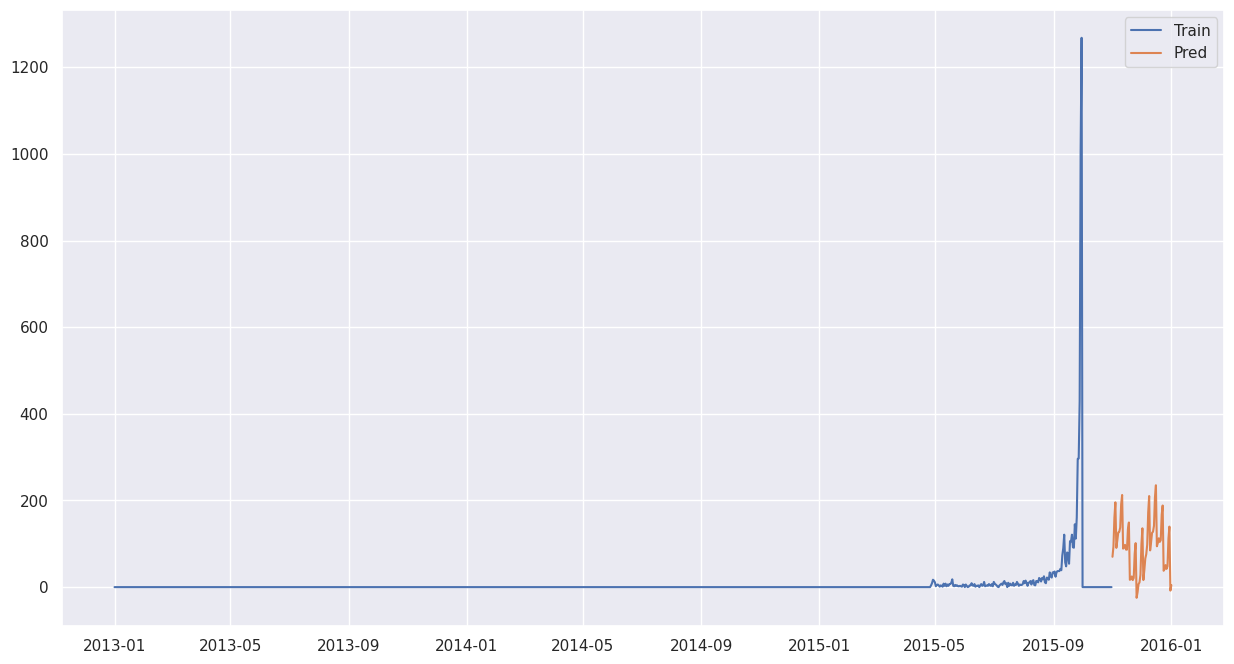

In [193]:
plot_forecast(prophet_cats_id_sales['cat_id_80'], test=False)

## Merge with test\_df

In [358]:
final_df = test_df.copy()
final_df = final_df.merge(shops_pred, how='left', on='shop_id')
final_df = final_df.merge(cat_pred, how='left', on='cat_id')
final_df = final_df.merge(items_pred, how='left', on='item_id')
final_df = final_df.merge(cats_shops_pred, how='left', on=['shop_id', 'cat_id'])
final_df.fillna(0, inplace=True)

In [359]:
final_df

ID  shop_id  item_id  cat_id  shops_n_sales  cats_n_sales  \
0            0        5     5037      19          34.00         62.38   
1            1        5     5320      55          34.00        136.88   
2            2        5     5233      19          34.00         62.38   
3            3        5     5232      23          34.00         71.56   
4            4        5     5268      20          34.00        415.41   
...        ...      ...      ...     ...            ...           ...   
214195  214195       45    18454      55          20.46        136.88   
214196  214196       45    16188      64          20.46         28.08   
214197  214197       45    15757      55          20.46        136.88   
214198  214198       45    19648      40          20.46        232.64   
214199  214199       45      969      37          20.46         90.05   

        items_n_sales  cat_shops_n_sales  
0                0.55               2.27  
1                0.00               2.75  
2                1.68               2.27  
3                1.03               2.22  
4                0.00               5.44  
...               ...                ...  
214195           0.02               2.33  
214196           0.04               0.50  
214197           0.24               2.33  
214198           0.08               2.08  
214199          -0.02               1.16  

[214200 rows x 8 columns]

In [446]:
final_df.to_csv('../raw_data/prophet/final.csv')

In [352]:
test_df

ID  shop_id  item_id  cat_id
0            0        5     5037      19
1            1        5     5320      55
2            2        5     5233      19
3            3        5     5232      23
4            4        5     5268      20
...        ...      ...      ...     ...
214195  214195       45    18454      55
214196  214196       45    16188      64
214197  214197       45    15757      55
214198  214198       45    19648      40
214199  214199       45      969      37

[214200 rows x 4 columns]

In [195]:
sample_df

ID  item_cnt_month
0            0             0.5
1            1             0.5
2            2             0.5
3            3             0.5
4            4             0.5
...        ...             ...
214195  214195             0.5
214196  214196             0.5
214197  214197             0.5
214198  214198             0.5
214199  214199             0.5

[214200 rows x 2 columns]

# Data Old and What?

## one

In [ ]:
shops_cats_sales = pd.pivot_table(
    sales_df, values='item_cnt_day',
    index=['shop_id', 'cat_id'], columns=['date'],
    aggfunc=np.sum 
)
shops_cats_sales.fillna(0, inplace=True)
#shops_cats_sales.reset_index(inplace=True)

In [ ]:
shops_cats_sales.T

In [ ]:
shops_sales

In [ ]:
shops_items_sales = pd.pivot_table(
    sales_df, values='item_cnt_day',
    index=['shop_id', 'item_id'], columns=['date_block_num'],
    aggfunc=np.sum 
)
shops_items_sales.fillna(0, inplace=True)
#shops_items_sales.reset_index(inplace=True)

In [ ]:
shops_items_sales

In [ ]:
shops_sales_month['final_id'] = shops_sales_month['shop_id'].astype(str) + "-" + shops_sales_month['item_id'].astype(str)
shops_sales_month.set_index('final_id', inplace=True)
shops_sales_month.drop(columns=['shop_id', 'item_id'], inplace=True)
shops_sales_month = shops_sales_month.T

In [ ]:
shops_sales_month

In [ ]:
plot_cols = ['0-32', '0-49', '59-22144', '59-22167']
plot_features = shops_sales_month[plot_cols]
plot_features.index = shops_sales_month.index
plot_features.plot(subplots = True);

## two

In [ ]:
sales_df[sales_df['shop_id'] == 10].sort_values("date").groupby(by='date').sum('item_cnt_day')

In [ ]:
shop_sales_month =pd.DataFrame({"date_block_num": range(34)})
type(shop_sales_month)

In [ ]:
total_month_dict = {}
for id in range(shops_df.shape[0]):
    shop_id = f"shop_id_{id}"
    df = sales_df[sales_df['shop_id'] == id].groupby(by='date_block_num').sum('item_cnt_day')
    total_month_dict[shop_id] = df.shape[0]
    shop_sales_month[shop_id] = df.item_cnt_day
shop_sales_month.fillna(0, inplace=True)
shop_sales_month.drop(columns=['date_block_num'], inplace=True)

In [ ]:
shop_sales_month

In [ ]:
closed_shops = shop_sales_month.iloc[31:34]
closed_shops = pd.DataFrame(shop_sales_month.iloc[31:34].sum()).T
closed_shops

In [ ]:
pd.DataFrame(shop_sales_month.iloc[31:34].sum()).head(60)

In [ ]:
plt.plot(shop_sales_month.shop_id_0)
plt.plot(shop_sales_month.shop_id_1)
plt.plot(shop_sales_month.shop_id_8)
plt.plot(shop_sales_month.shop_id_9)

plt.plot(shop_sales_month.shop_id_11)
plt.plot(shop_sales_month.shop_id_13)
plt.plot(shop_sales_month.shop_id_17)
plt.plot(shop_sales_month.shop_id_20)
plt.plot(shop_sales_month.shop_id_23)
plt.plot(shop_sales_month.shop_id_27)

plt.plot(shop_sales_month.shop_id_29)
plt.plot(shop_sales_month.shop_id_30)
plt.plot(shop_sales_month.shop_id_32)
plt.plot(shop_sales_month.shop_id_33)
plt.plot(shop_sales_month.shop_id_40)
plt.plot(shop_sales_month.shop_id_27)


plt.plot(shop_sales_month.shop_id_43)
plt.plot(shop_sales_month.shop_id_51)
plt.plot(shop_sales_month.shop_id_54)
plt.plot(range(34))

In [ ]:
plt.plot(shop_sales_month.shop_id_27)
#plt.plot(shop_sales_month.shop_id_41)
#plt.plot(shop_sales_month.shop_id_42)
#plt.plot(shop_sales_month.shop_id_43)
#plt.plot(shop_sales_month.shop_id_44)
#plt.plot(shop_sales_month.shop_id_45)
#plt.plot(shop_sales_month.shop_id_46)

In [ ]:
sns.displot(total_month_dict, bins=34)
plt.xlim(1, 35, )

In [ ]:
total_month_dict

In [ ]:
open_shops